In [2]:
import numpy as np
import os
import h5py
from getdist import plots, MCSamples
import getdist
import dynesty 
from dynesty import plotting as dyplot
import pickle

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import utils

In [3]:
pickle_dir = f'../products/dynesty_results'

In [4]:
cwp = 'deepskyblue'
cupf = 'green'
cmcf = 'magenta'

In [5]:
param_labels = {'Omega_m': '\Omega_m', 
                'Omega_b': '\Omega_b', 
                'sigma_8': '\sigma_8', 
                'h': 'h', 
                'n_s': 'n_s',
                'N_eff': 'N_{eff}', 
                'w': 'w', 
                'M_sat': 'M_{sat}', 
                'alpha': r'\alpha', 
                'M_cut': 'M_{cut}', 
                'sigma_logM': '\sigma_{logM}', 
                'v_bc': 'v_{bc}', 
                'v_bs': 'v_{bs}', 
                'c_vir': 'c_{vir}', 
                'f': 'f', 
                'f_env': 'f_{env}', 
                'delta_env': '\delta_{env}', 
                'sigma_env': '\sigma_{env}'}

In [6]:
cosmo_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
hod_params = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f']
ab_params = ['f_env', 'delta_env', 'sigma_env']
hod_interest = ['M_sat', 'M_cut', 'alpha', 'f_env', 'delta_env']
all_interest = ['Omega_m', 'sigma_8', 'M_sat', 'f_env', 'delta_env']
key_params = ['Omega_m', 'sigma_8', 'M_sat', 'v_bc', 'v_bs', 'f', 'f_env']
all_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w', 'M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']

In [7]:
def get_h5(chaintag): 
    chain_fn = f'../chains/chains_{chaintag}.h5'
    if os.path.exists(chain_fn):
        fw = h5py.File(chain_fn, 'r')
        #chain_dset = fw['chain']
        #print(f"{chaintag}: {chain_dset}")
        #print(f"dlogz: {fw.attrs['dlogz']}")
        #print(f"seed: {fw.attrs['seed']}")
        return fw
    else:
        print(f"chain {chain_fn} doesn't exist!")

In [8]:
def check_chains(chaintag): 
    chain_fn = f'../chains/chains_{chaintag}.h5'
    if os.path.exists(chain_fn):
        fw = h5py.File(chain_fn, 'r')
        chain_dset = fw['chain']
        print(f"{chaintag}: {chain_dset}")
        print(f"dlogz: {fw.attrs['dlogz']}")
        print(f"seed: {fw.attrs['seed']}")
        fw.close()
    else:
        print(f"chain {chain_fn} doesn't exist!")

In [9]:
def plot_chains(chaintag, show_walkers=False, show_params=None, figure=None, nsteps=None, color='blue'): 
    #chaintag = 'wp_c3h3_Msat_fenv_xlong_diag'
    chain_fn = f'../chains/chains_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')

    chain_dset = fw['chain']
    chain = np.array(chain_dset)
    lnprob_dset = fw['lnprob']
    lnprob = np.array(lnprob_dset)
    param_names = fw.attrs['param_names']
    true_values = fw.attrs['true_values']
    if nsteps:
        chain = chain[:,:nsteps,:]
    fw.close()
    
    if show_params:    
        idxs = []
        for sp in show_params:
            idxs.append(np.where(param_names == sp))
        idxs = np.array(idxs).flatten()
        chain = chain[:,:,idxs]
        param_names = show_params
        true_values = true_values[idxs]

    nwalkers, nchain, ndim = chain.shape

    for k in range(ndim):
        plt.figure()
        pname = param_names[k]
        for j in range(nwalkers):
            plt.title(pname)
            plt.plot(chain[j,:,k], alpha=1)
            low, high = bounds[pname]
            plt.axhline(low, ls=':', color='k')
            plt.axhline(high, ls=':', color='k')
            plt.axhline(true_values[k], ls='-', lw=2, color='k')
    plt.xlabel('step')

    plt.figure()
    for j in range(nwalkers):
        plt.plot(lnprob[j,:], alpha=1)
    plt.ylabel('lnprob')
    plt.xlabel('step')

In [21]:
def plot_contours_resample(chaintags, legend_labels=None, params_toplot=None, nsteps=None, colors=None, 
                  legend_loc='upper center', legend_fontsize=20, weight_with_dynesty=False, use_res=[]): 
    # if not weight_with_dynesty, then weight with MCSamples
    
    sample_arr = []
    for i, chaintag in enumerate(chaintags):
        chain_fn = f'../chains/chains_{chaintag}.h5'
        fw = h5py.File(chain_fn, 'r')
        
        if use_res[i]:
            pickle_dir = f'../products/dynesty_results'
            pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
            with open(pickle_fn, 'rb') as pf:
                res = pickle.load(pf)
                chain = res['samples']
                lnweight = np.array(res['logwt'])
                lnevidence = np.array(res['logz'])
                
        else:  
            chain_dset = fw['chain']
            chain = np.array(chain_dset)[0]
            lnweight_dset = fw['lnweight']
            lnevidence_dset = fw['lnevidence']
            lnweight = np.array(lnweight_dset)[0] #[0] bc an extra array dim
            lnevidence = np.array(lnevidence_dset)[0]
          
        param_names = fw.attrs['param_names']
        true_values = fw.attrs['true_values']
        
        fw.close()

        if params_toplot is not None:    
            idxs = []
            for pm in params_toplot:
                idxs.append(np.where(param_names == pm))
            idxs = np.array(idxs).flatten()
            chain = chain[:,idxs]
            param_names = params_toplot
            true_values = true_values[idxs]
        
        nchain, ndim = chain.shape
        print(nchain, ndim)
        samples = chain.reshape(-1, ndim)
        labels = [param_labels[pn] for pn in param_names]
        ranges = [bounds[pn] for pn in param_names]

        #[-1] bc just care about final evidence value
        weights = np.exp(lnweight - lnevidence[-1]) 
        weights = weights.flatten()

        samples = np.empty((nchain, ndim))
        for nd in range(ndim):
            cn = chain[:,nd].flatten()
            if weight_with_dynesty:
                samples[:,nd] = dynesty.utils.resample_equal(cn, weights)
            else:
                samples[:,nd] = cn
        
        if weight_with_dynesty:
            weights = None
        
        # have not gotten ranges to work
        samps = MCSamples(names=param_names, labels=labels)#, ranges=ranges)
        # for some reason get slightly diff answer if don't use setSamples and pass them straight to MCSamples!
        samps.setSamples(samples, weights=weights)
        sample_arr.append(samps)

    g = plots.get_subplot_plotter()
    g.settings.alpha_filled_add=0.4
    g.settings.figure_legend_frame = False
    g.settings.legend_fontsize = legend_fontsize
    g.settings.axis_marker_lw = 1.0
    g.settings.axis_marker_color = 'dimgrey'
    g.triangle_plot(sample_arr, filled=True, contour_colors=colors, names=param_names,
                   legend_labels=legend_labels, markers=true_values, title_limit=1, legend_loc=legend_loc,
                   )
    return g

In [11]:
def plot_weights(chaintag): 
    
    chain_fn = f'../chains/chains_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')
    
    lnweight_dset = fw['lnweight']
    lnevidence_dset = fw['lnevidence']
    #[-1] bc just care about final evidence value
    
    lnweight = np.array(lnweight_dset)[0] #bc accidentally a an extra array dim
    lnevidence = np.array(lnevidence_dset)[0]
    weights = np.exp(lnweight - lnevidence[-1]) 

    fw.close()

    plt.figure()
    plt.plot(weights)
    plt.xlabel('sample number')
    plt.ylabel('weight')

In [12]:
bounds = utils.get_emulator_bounds()

In [13]:
pickle_dir = f'../products/dynesty_results'

# dynesty plots

Summary
nlive: 196
niter: 3005
ncall: 67093
eff(%):  4.771
logz: -21.695 +/-  0.267
None


<Figure size 288x216 with 0 Axes>

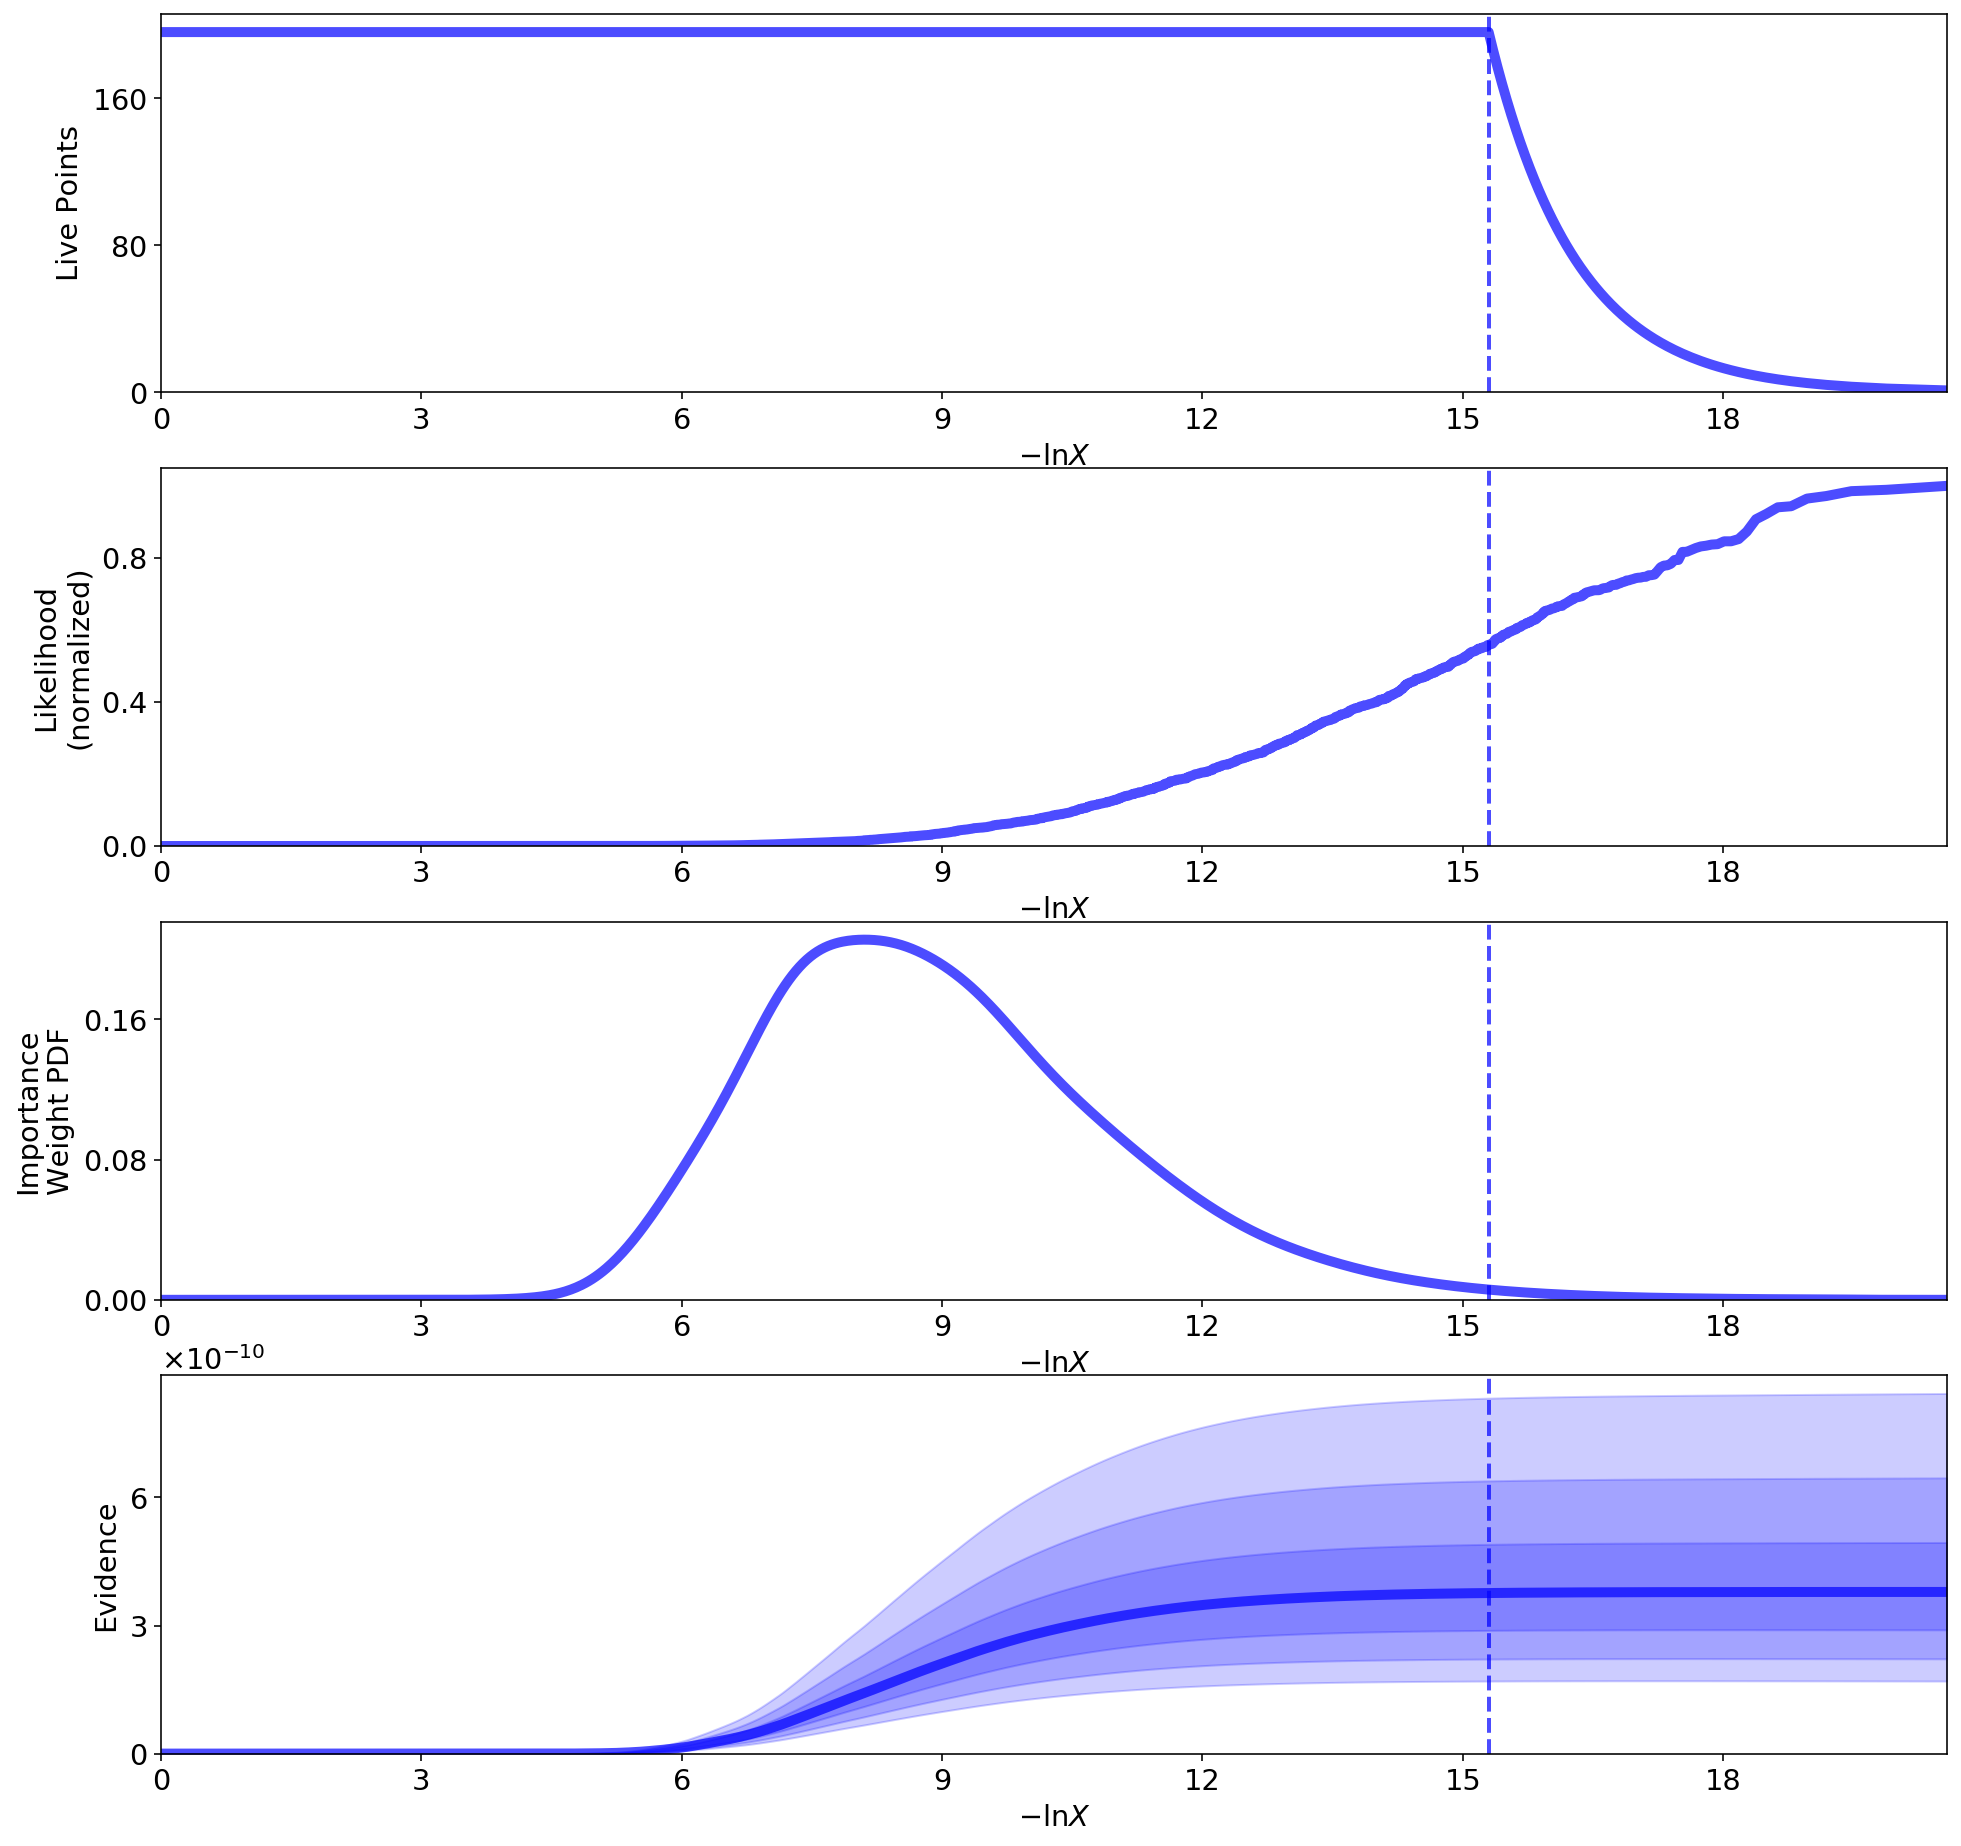

In [13]:
chaintag = 'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    print(res.summary())
    plt.figure(figsize=(4,3))
    dyplot.runplot(res)

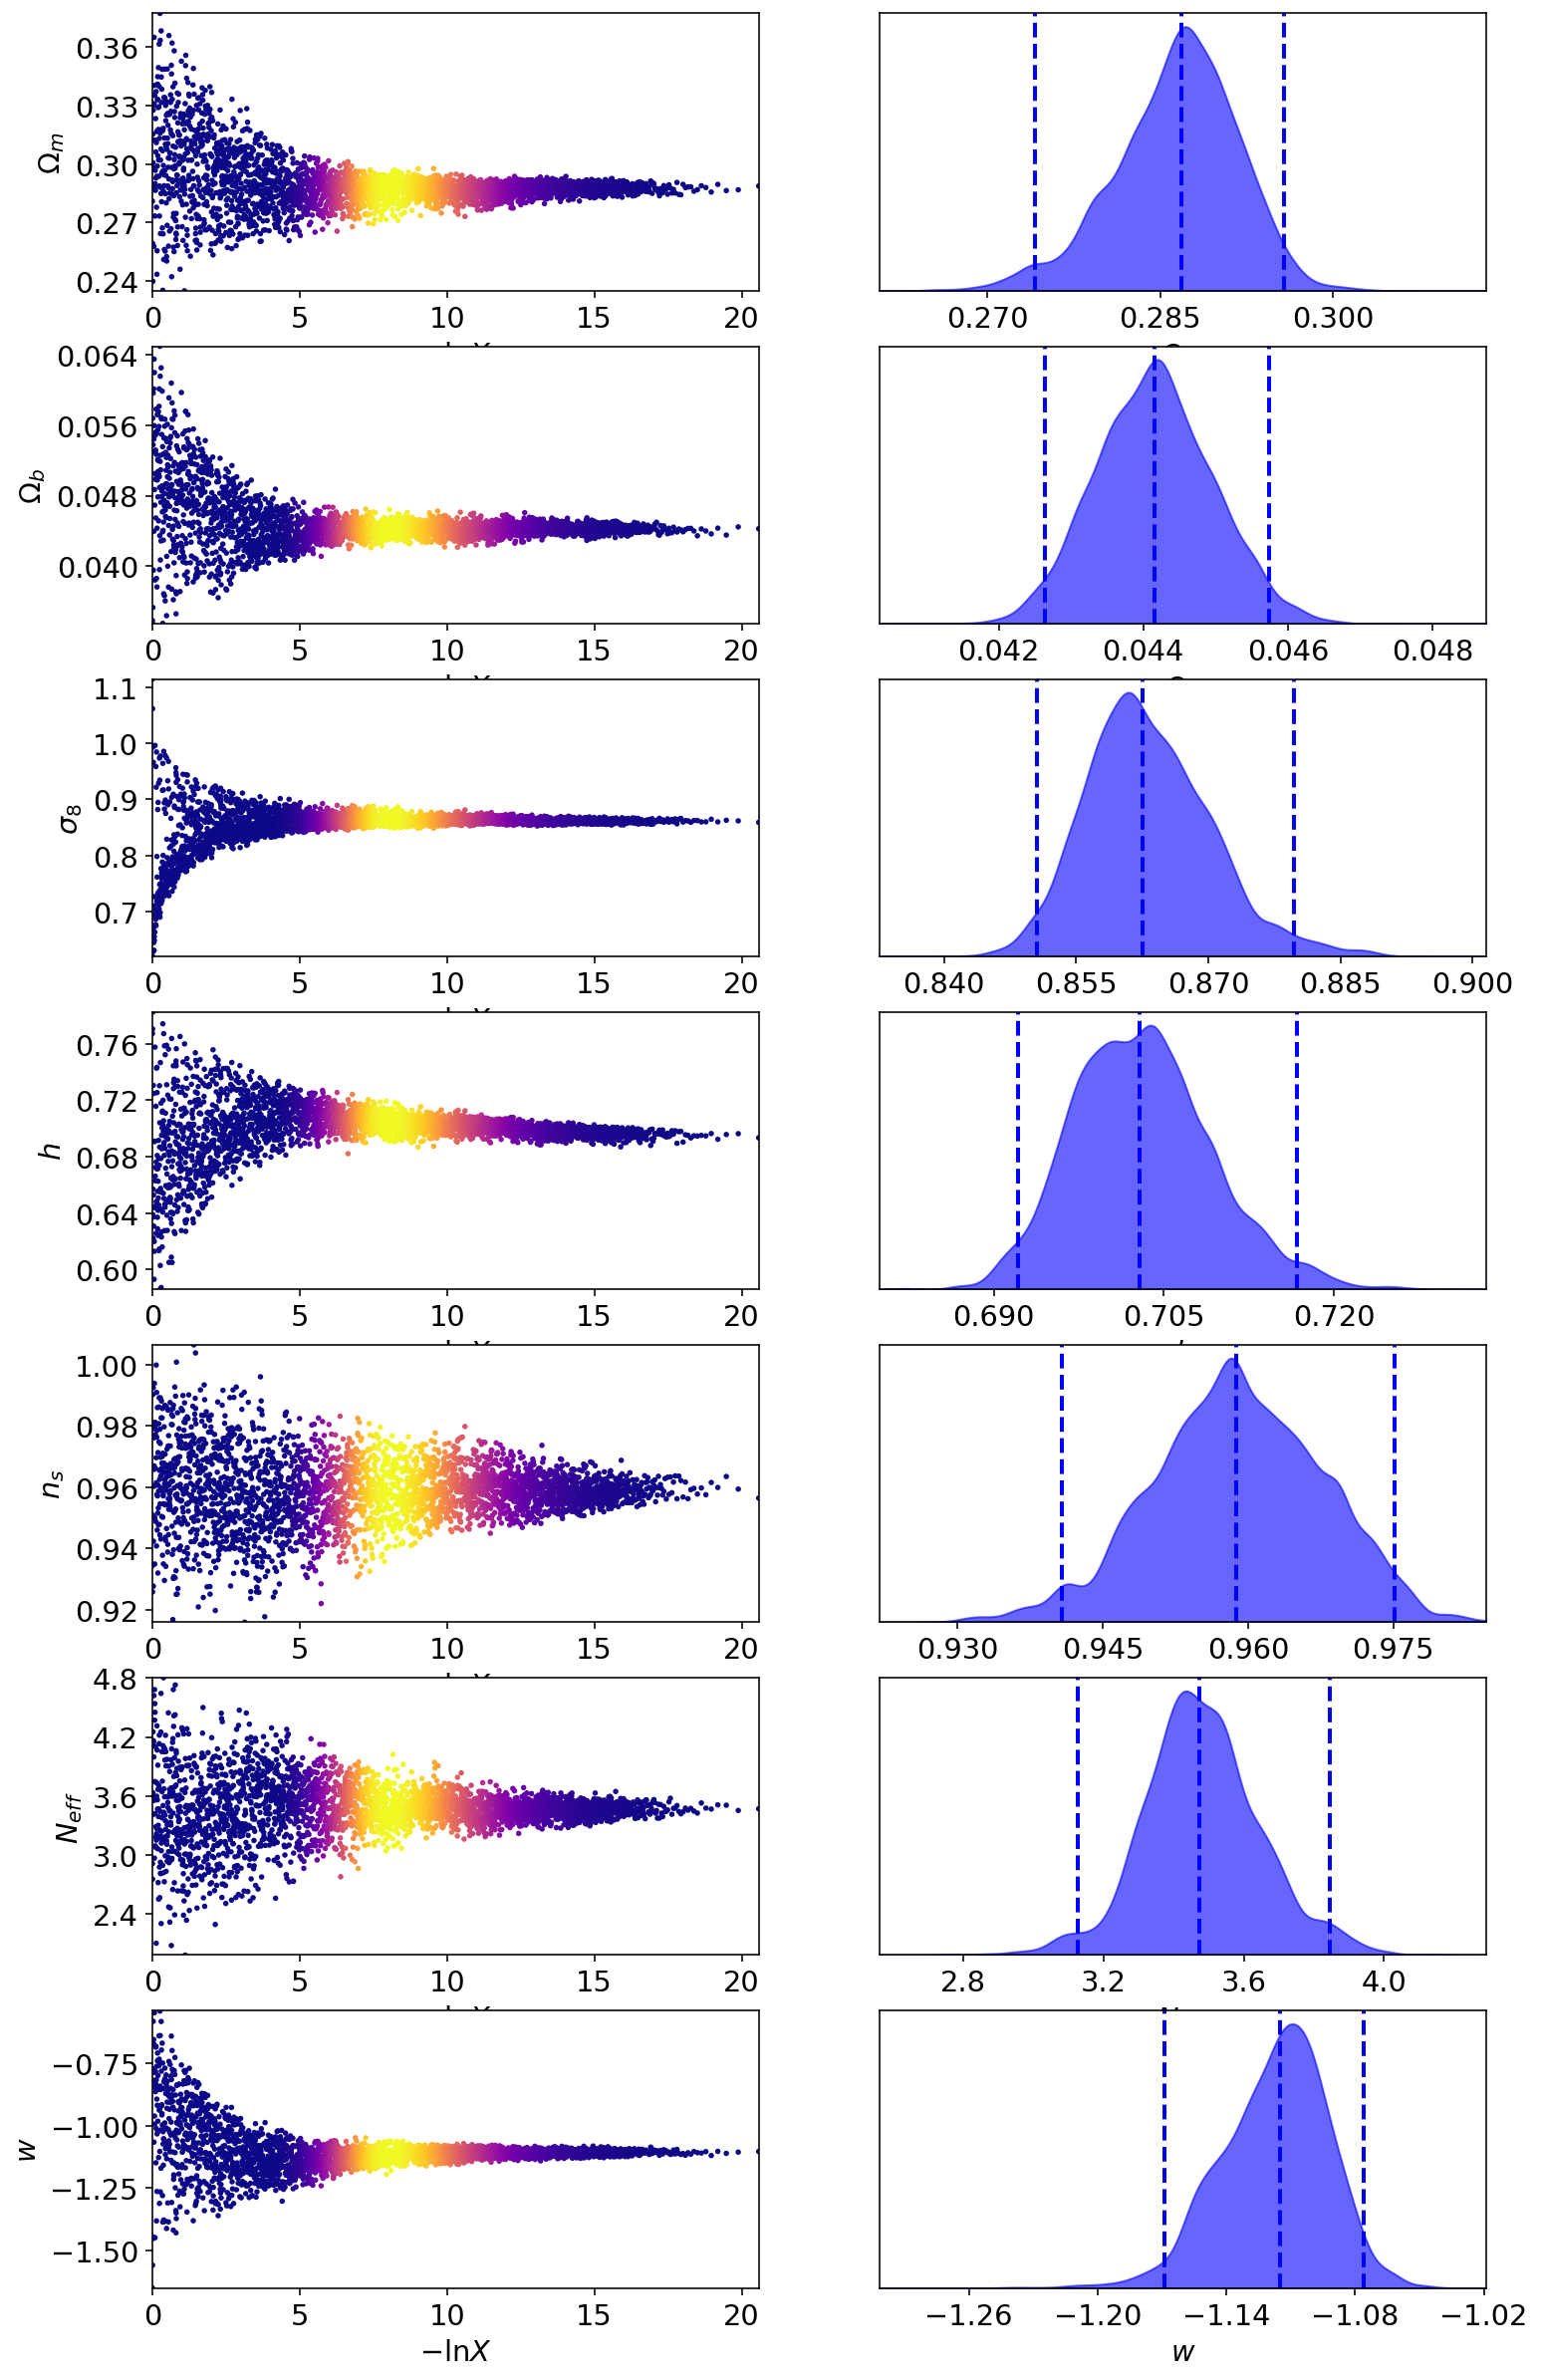

In [14]:
chaintag = 'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    labels = [f'${param_labels[c]}$' for c in cosmo_params]
    dyplot.traceplot(res, labels=labels)

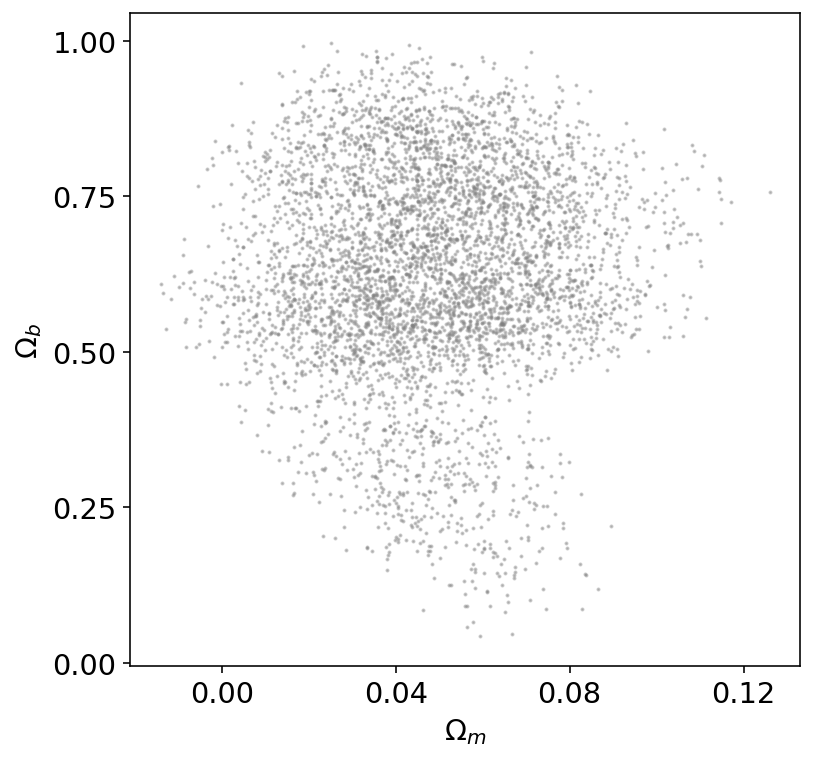

In [15]:
chaintag = 'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    labels = [f'${param_labels[c]}$' for c in cosmo_params]
    dyplot.boundplot(res, dims=(0,1), it=2900, labels=labels)

dict_keys(['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'])


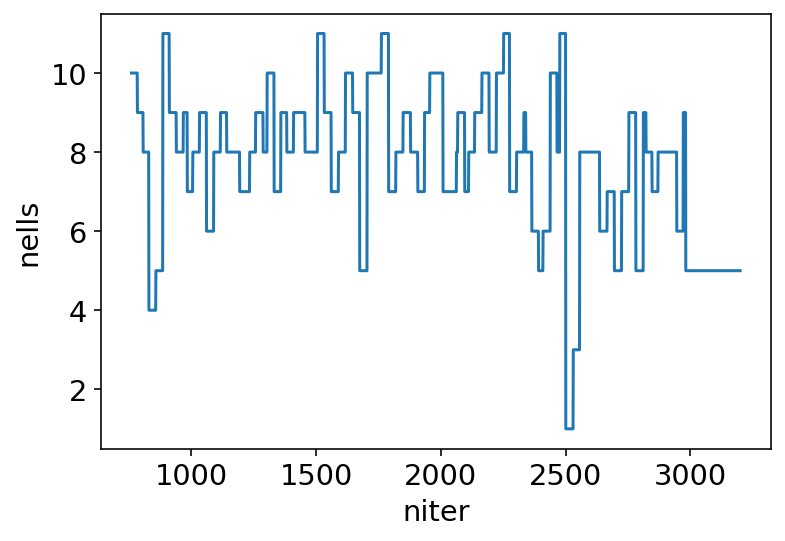

In [16]:
chaintag = 'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg'
pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    print(res.keys())
    nsteps = len(res['bound_iter'])
    nells = np.empty(nsteps)
    for i in range(nsteps):
        iell = res['bound_iter'][i]
        if iell==0:
            nells[i] = np.NaN
            continue
        nells[i] = res['bound'][iell].nells
    
    plt.plot(nells)
    plt.xlabel('niter')
    plt.ylabel("nells")
    

Summary
nlive: 1296
niter: 48236
ncall: 1150311
eff(%):  4.306
logz: -41.501 +/-  0.194
None


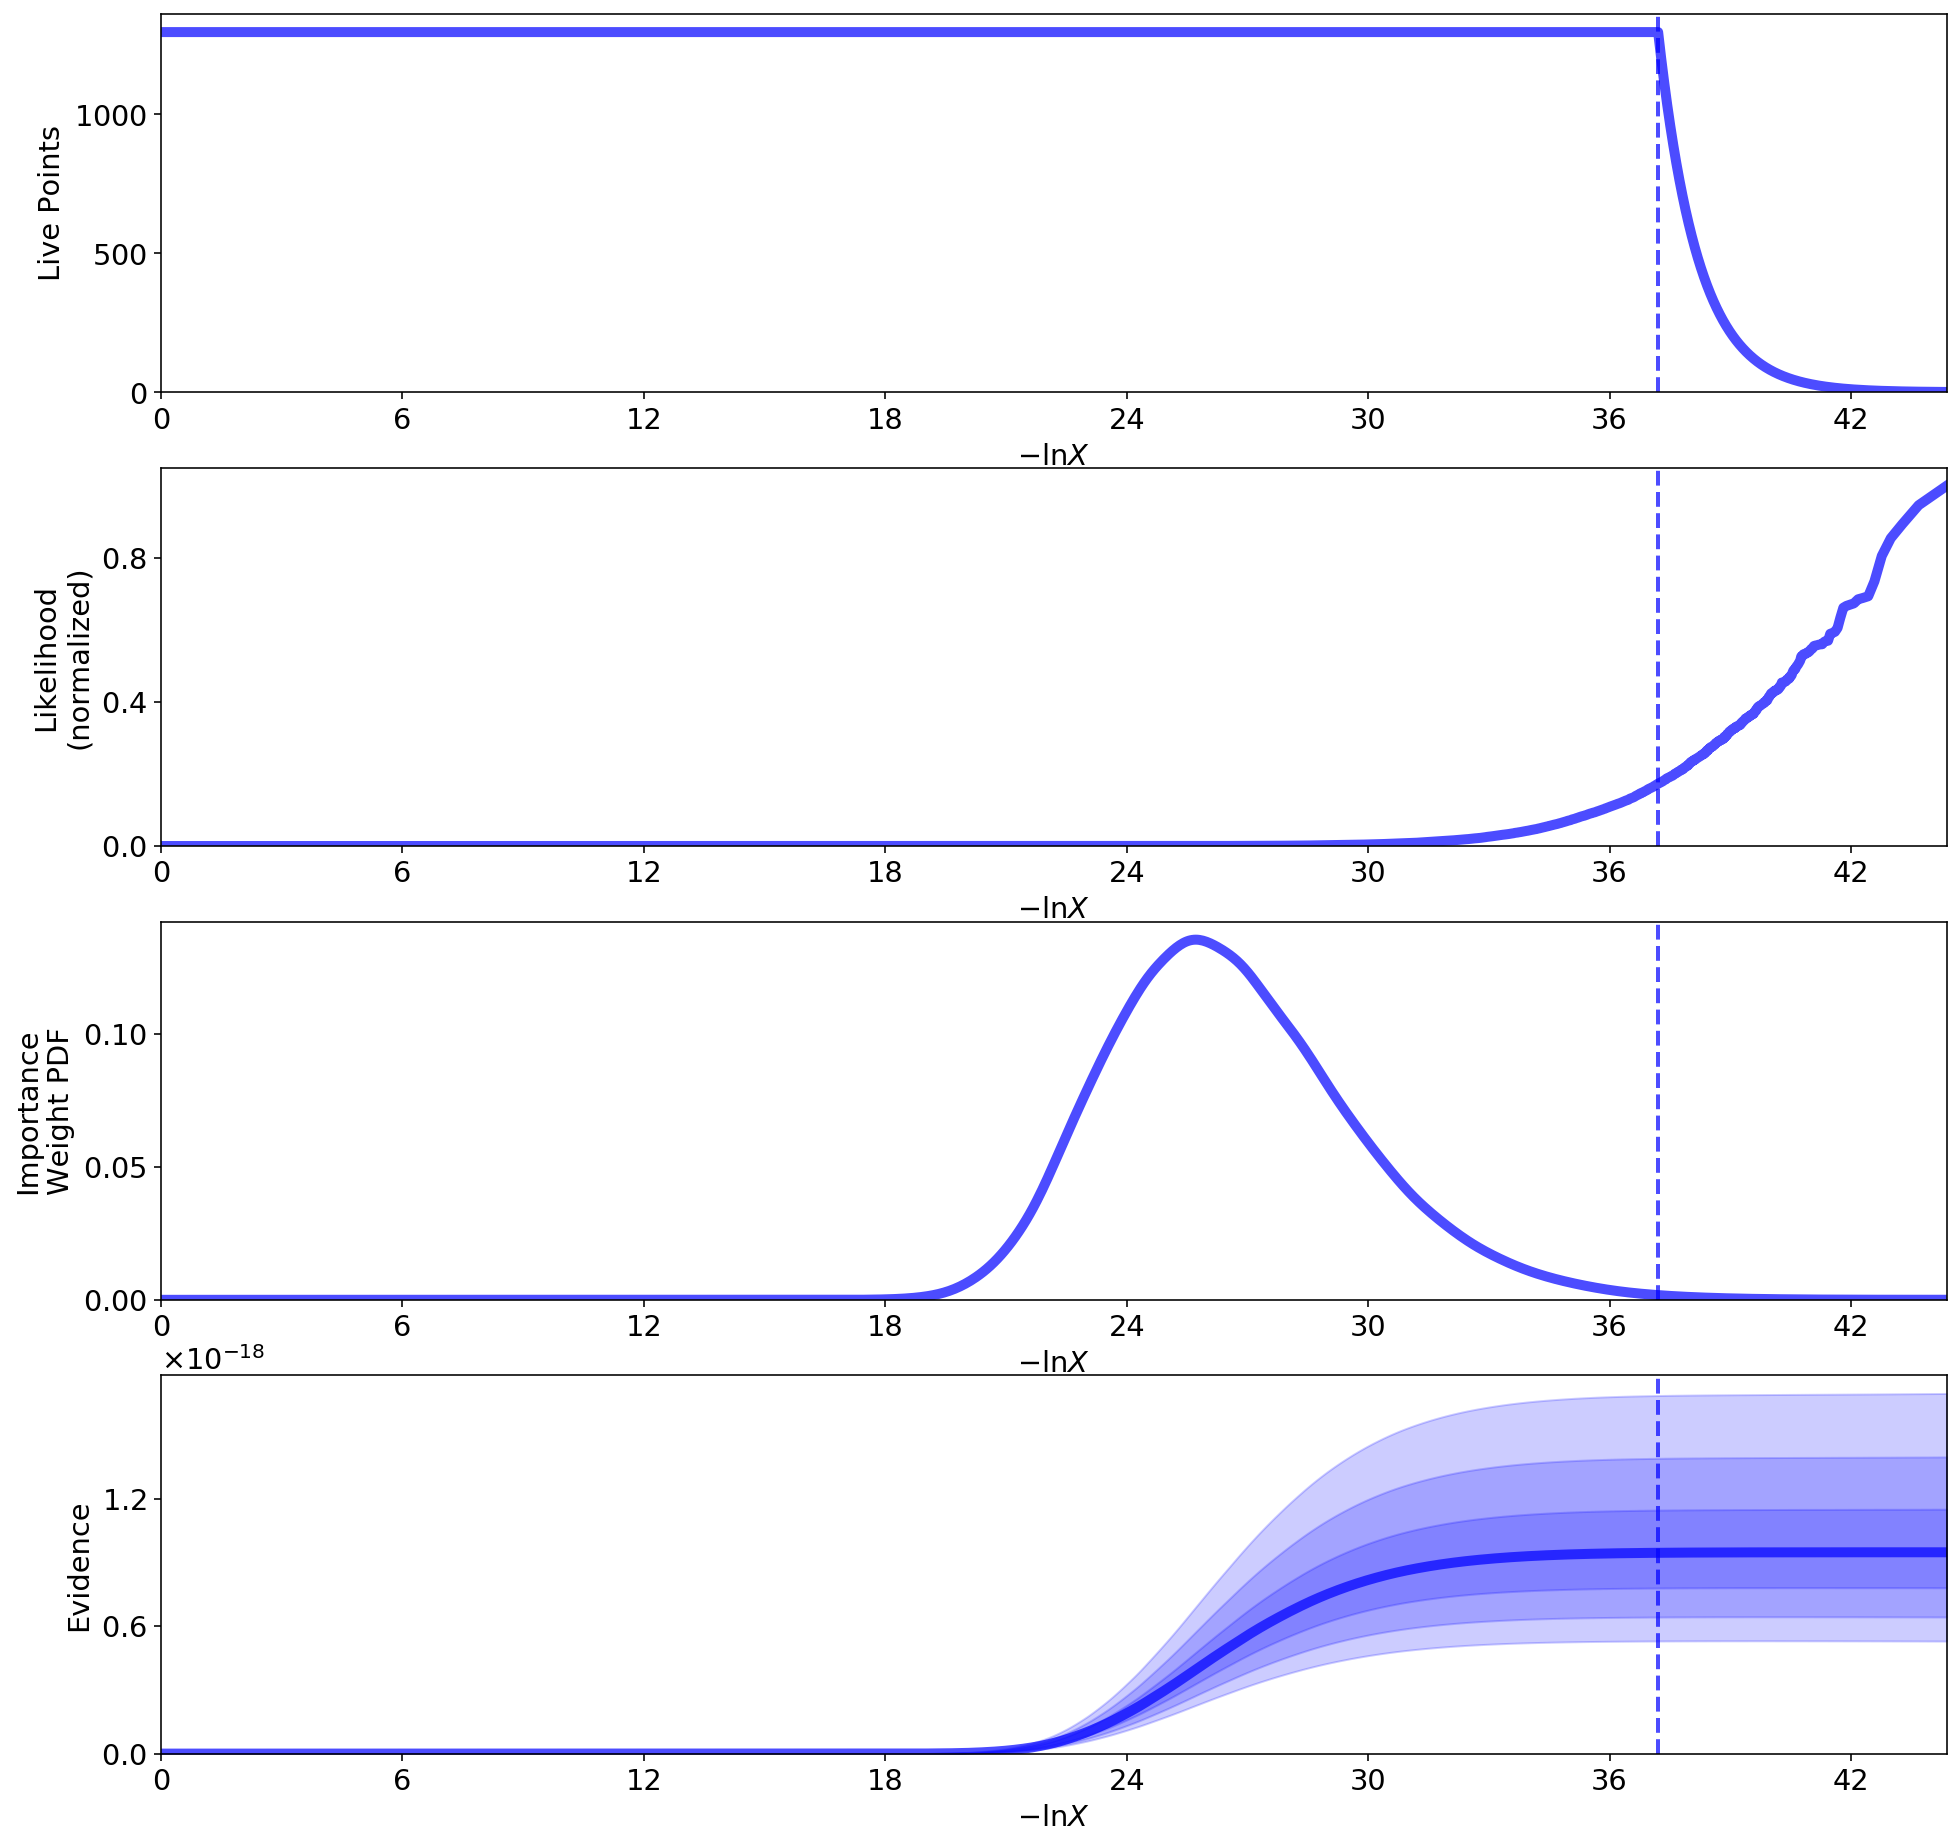

In [23]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    print(res.summary())
    dyplot.runplot(res)

Summary
nlive: 1296
niter: 48236
ncall: 1150311
eff(%):  4.306
logz: -41.501 +/-  0.194
None


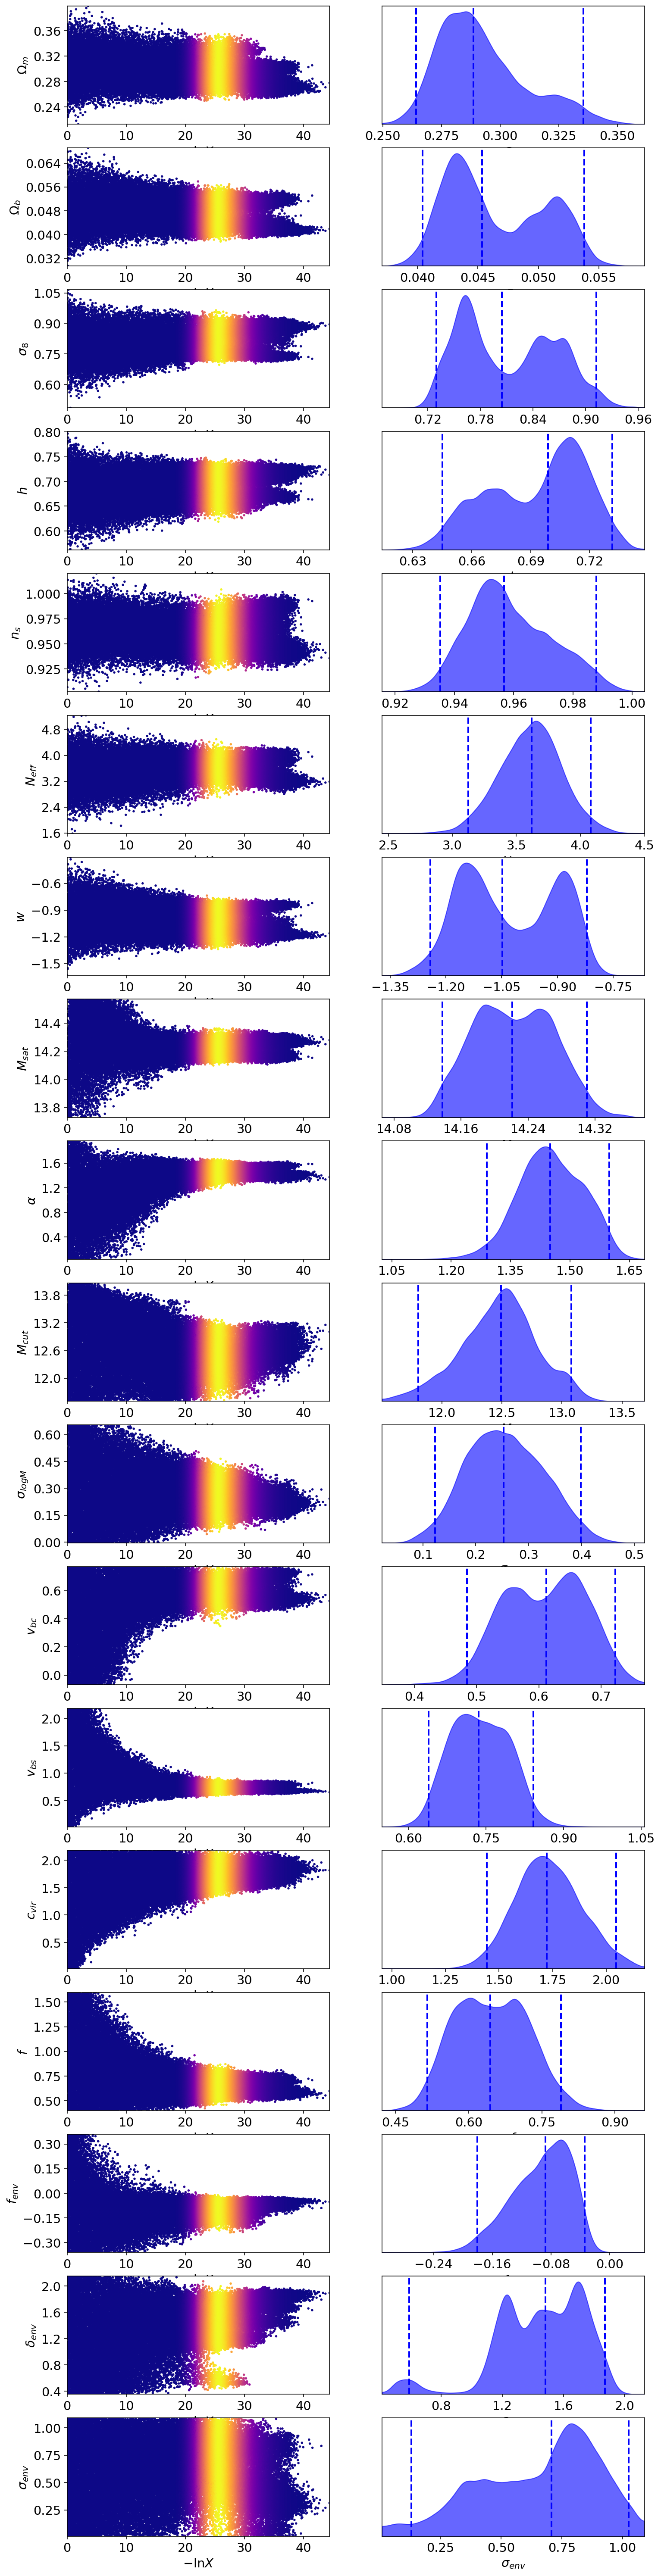

In [27]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    print(res.summary())
    labels = [f'${param_labels[c]}$' for c in all_params]
    dyplot.traceplot(res, labels=labels)

dict_keys(['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'])


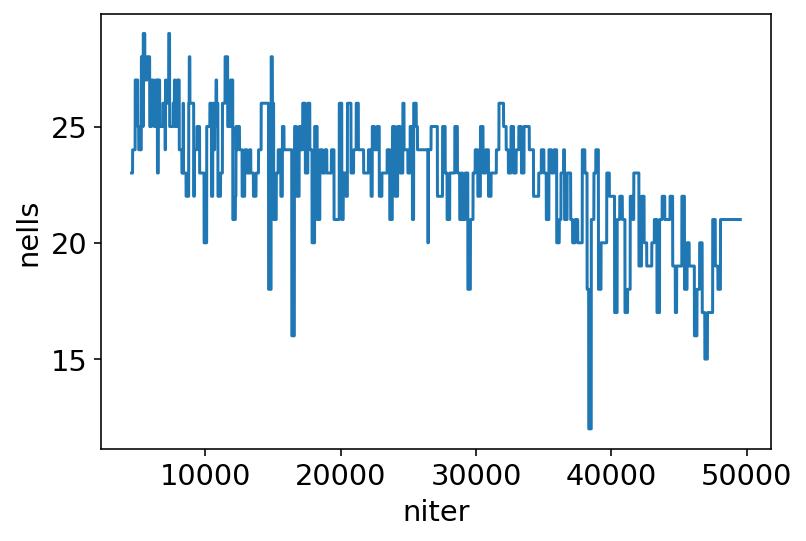

In [63]:
chaintag = 'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg'
pickle_fn = f'{pickle_dir}/results_{chaintag}.pkl'
with open(pickle_fn, 'rb') as pf:
    res = pickle.load(pf)
    print(res.keys())
    nsteps = len(res['bound_iter'])
    nells = np.empty(nsteps)
    for i in range(nsteps):
        iell = res['bound_iter'][i]
        if iell==0:
            nells[i] = np.NaN
            continue
        nells[i] = res['bound'][iell].nells
    
    plt.plot(nells)
    plt.xlabel('niter')
    plt.ylabel("nells")
    

<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
3201 7
(3201, 7) (3201,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
3179 7
(3179, 7) (3179,)


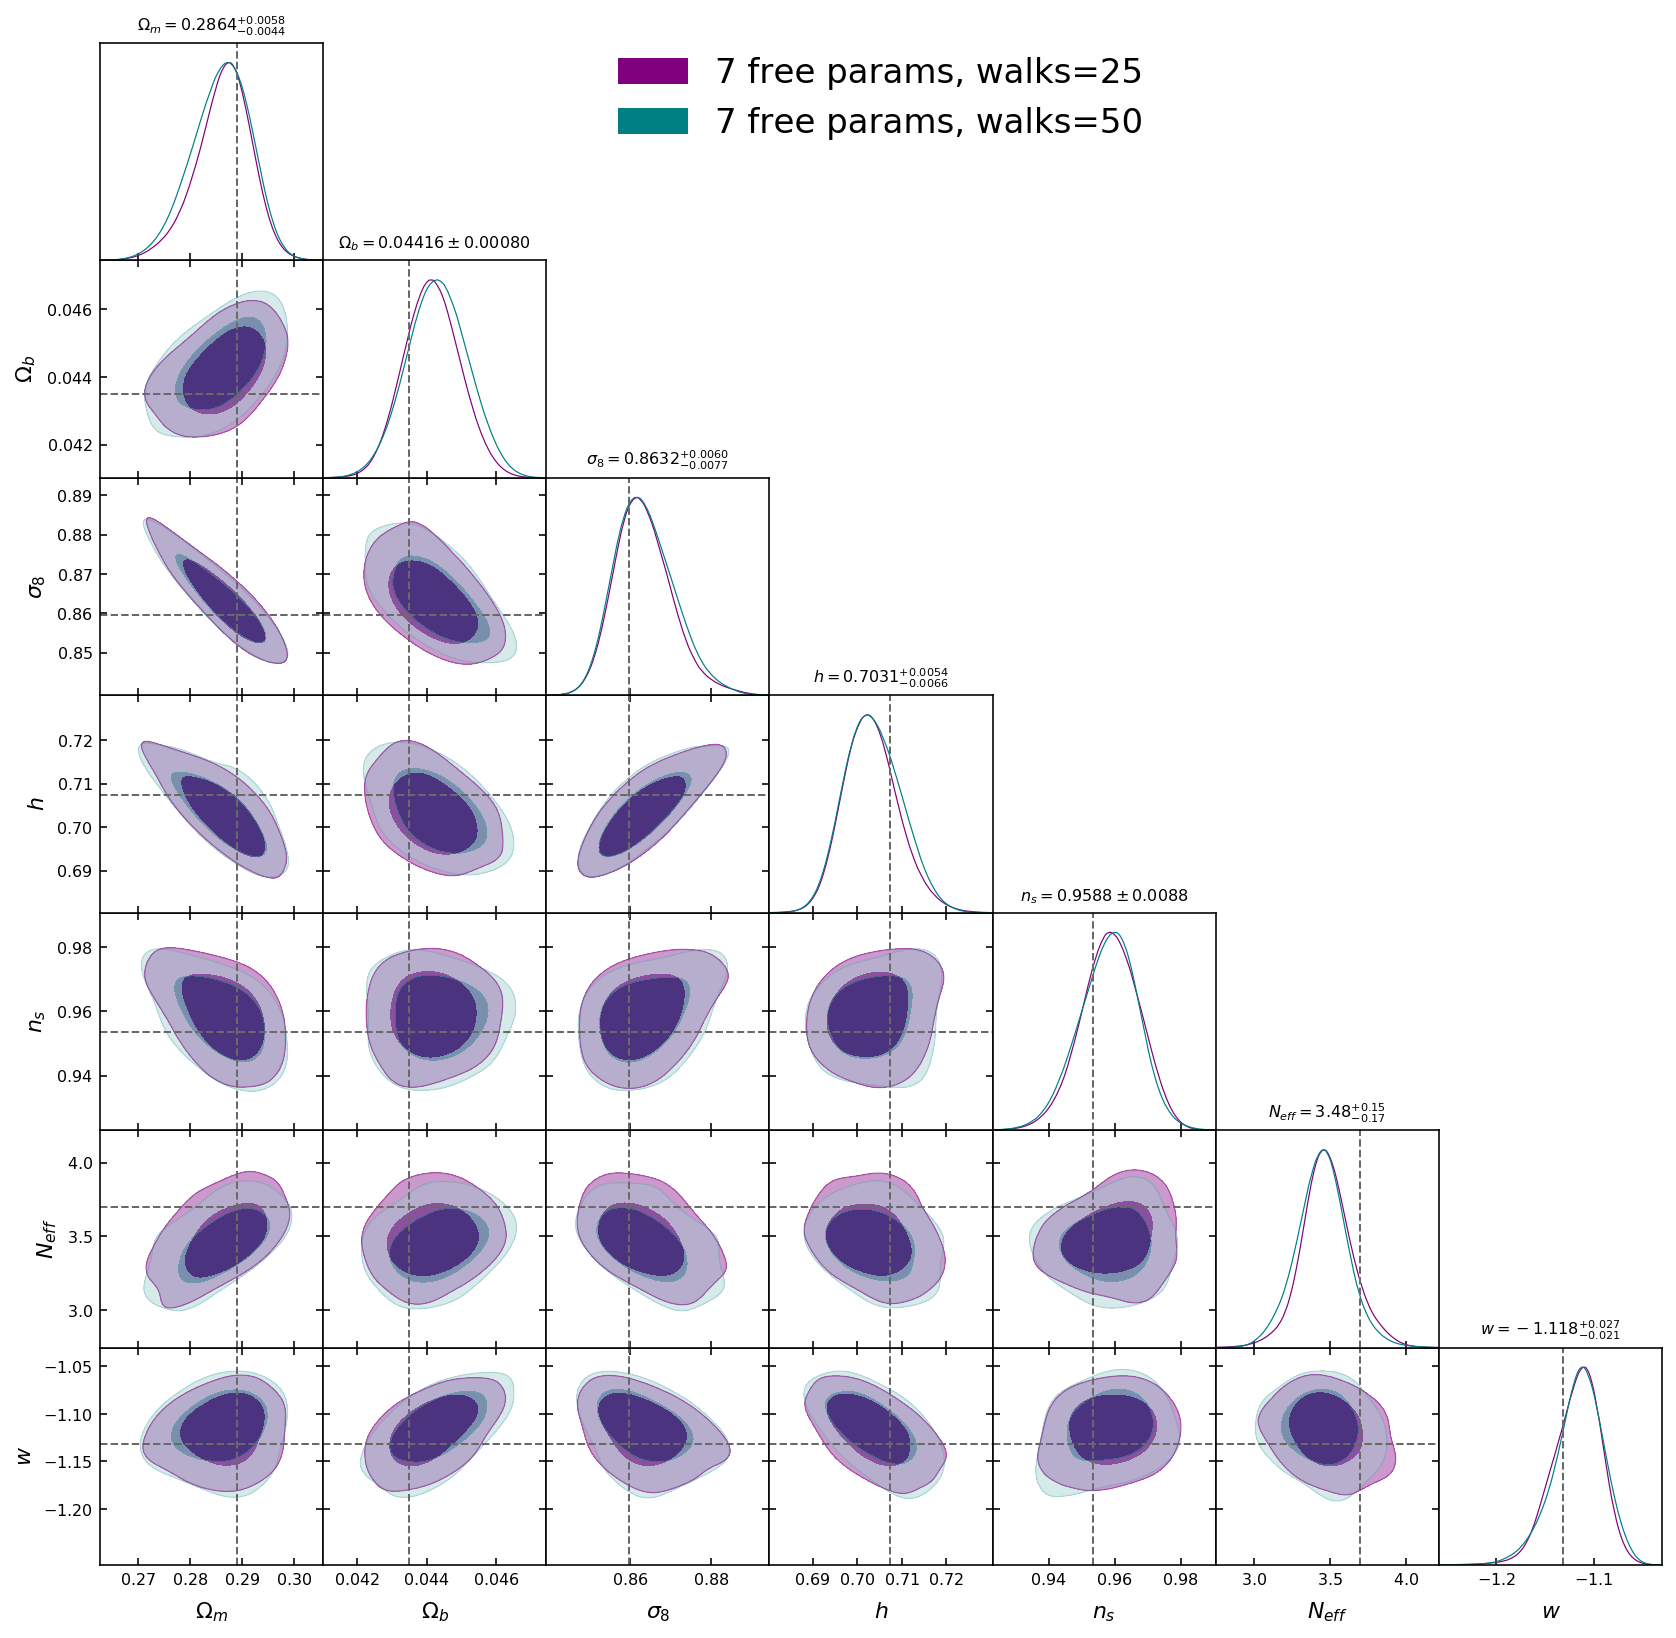

In [26]:
# checking that plotting from res is same
legend_labels = ['7 free params, walks=25',
                 '7 free params, walks=50']
chaintags = ['wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg_walks50']
colors = ['purple', 'teal']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[False, False],
                      legend_labels=legend_labels, params_toplot=cosmo_params)

<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27912 7
(27912, 7) (27912,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
28172 7
(28172, 7) (28172,)


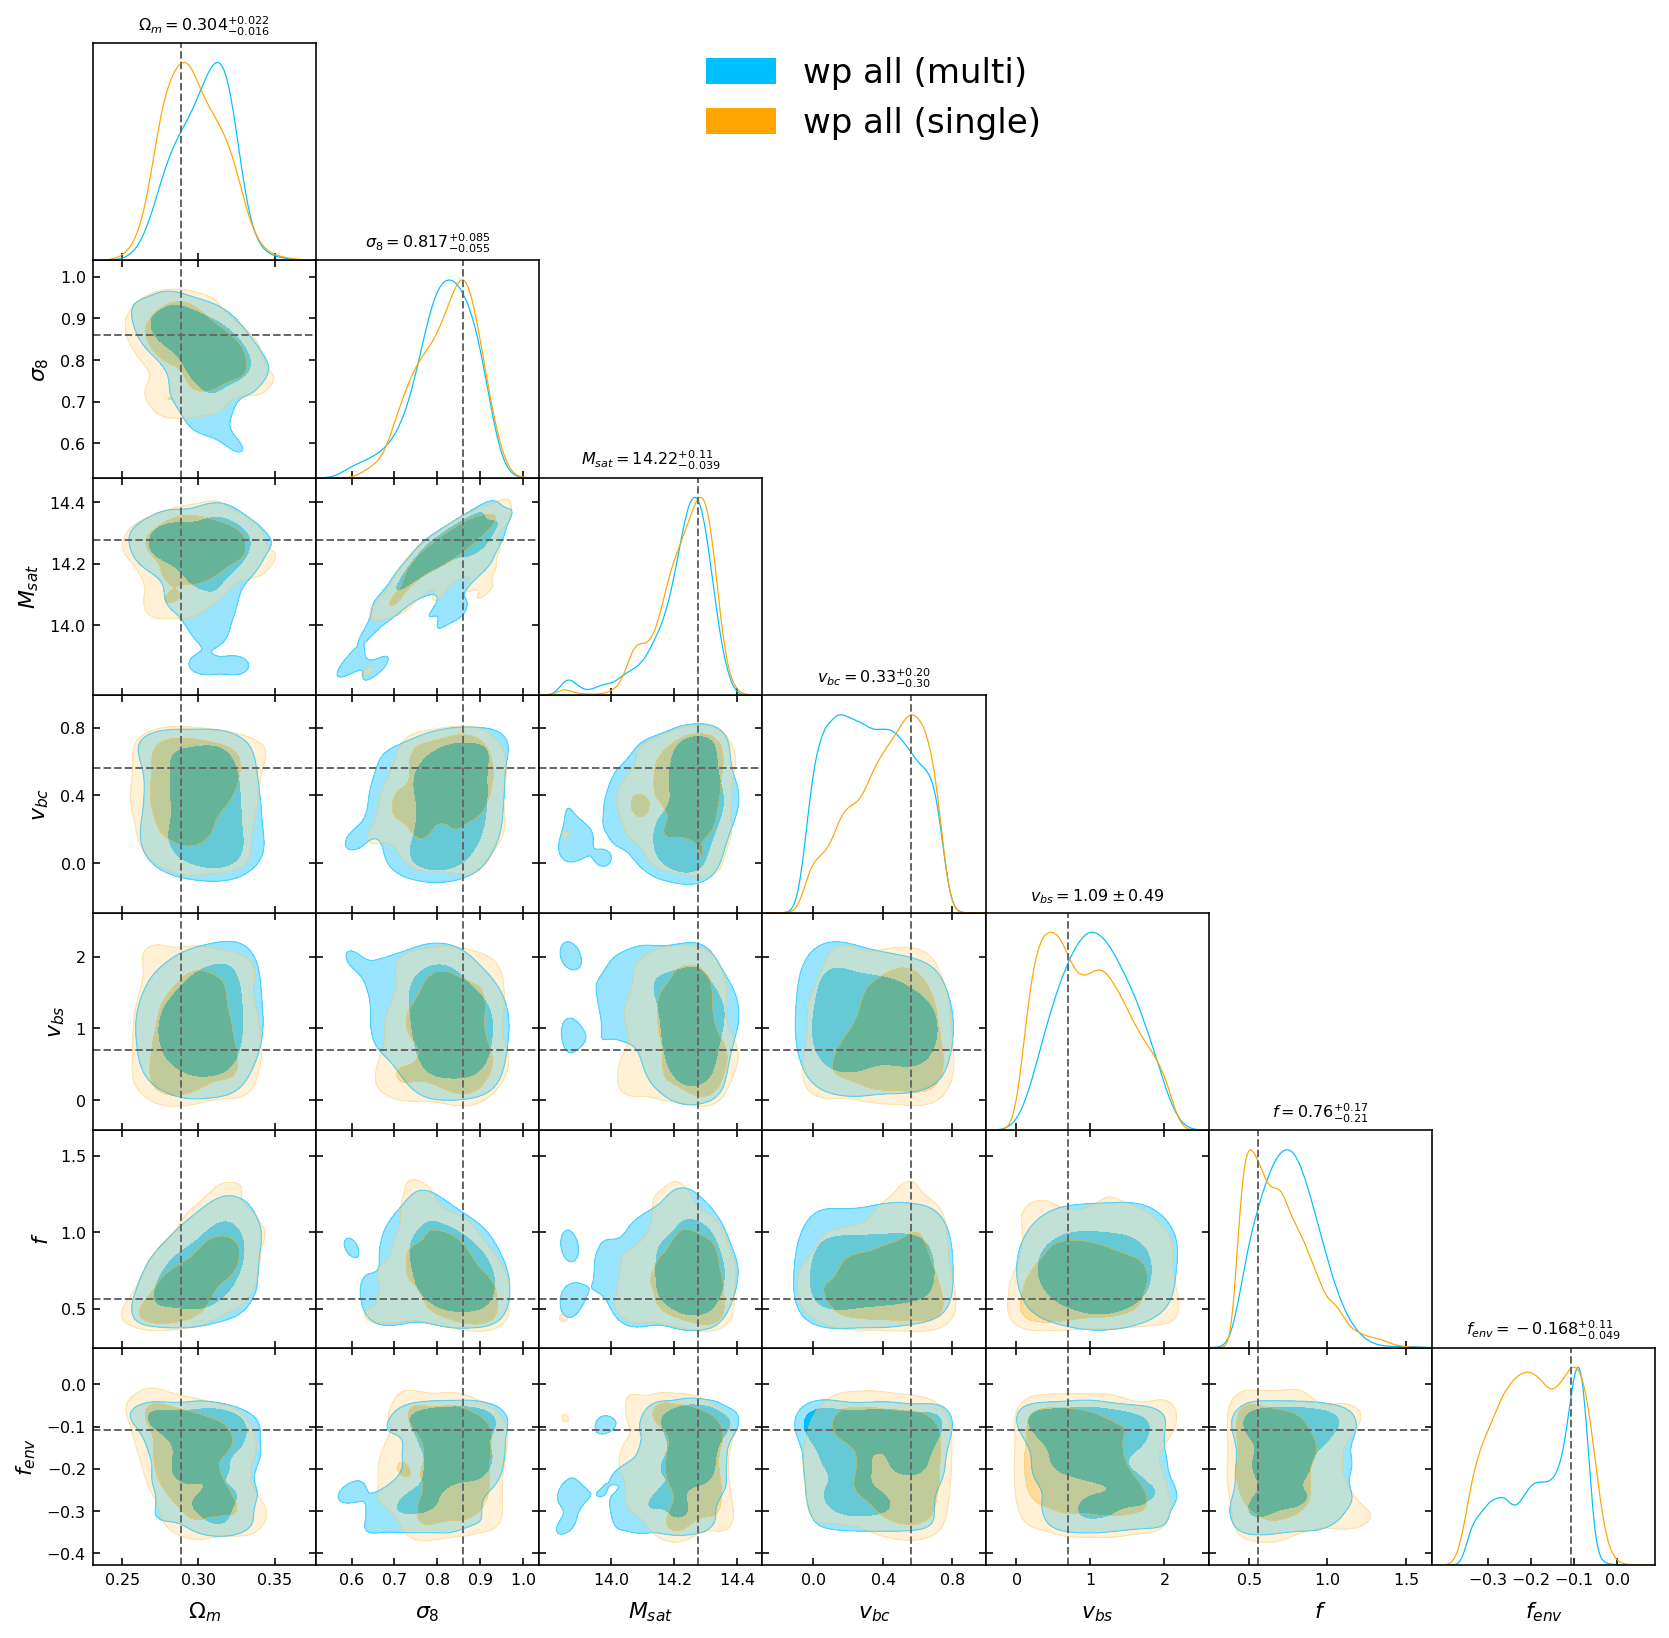

In [13]:
# checking that plotting from res is same
legend_labels = ['wp all (multi)',
                 'wp all (single)']
chaintags = ['wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_single']
colors = [cwp, 'orange']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[True, True],
                      legend_labels=legend_labels, params_toplot=key_params)

<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27912 7
(27912, 7) (27912,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
28172 7
(28172, 7) (28172,)


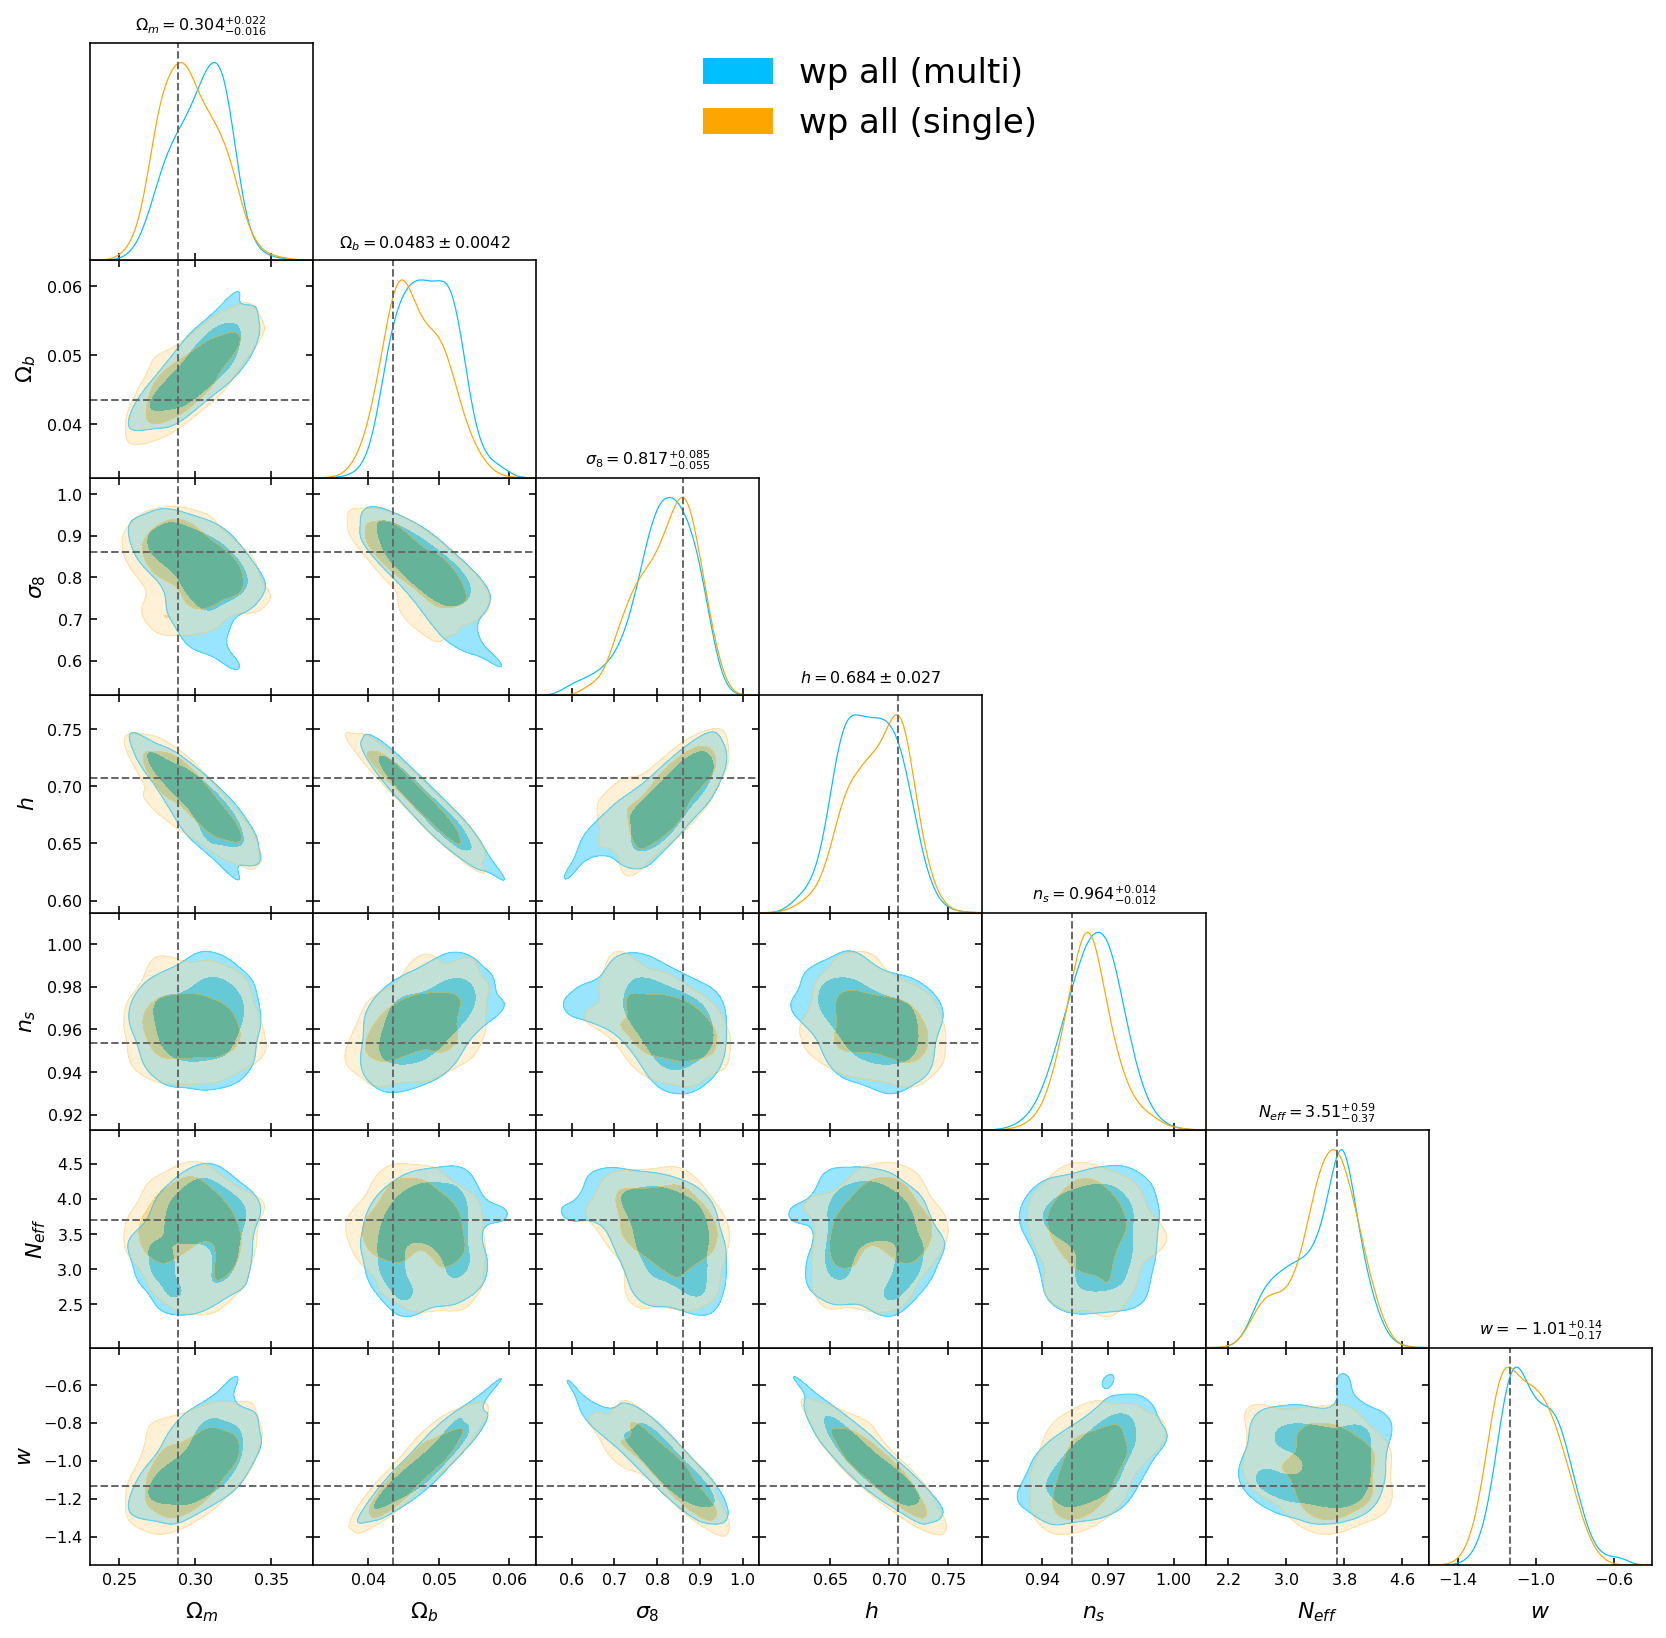

In [15]:
# checking that plotting from res is same
legend_labels = ['wp all (multi)',
                 'wp all (single)']
chaintags = ['wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_single']
colors = [cwp, 'orange']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[True, True],
                      legend_labels=legend_labels, params_toplot=cosmo_params)

<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27912 8
(27912, 8) (27912,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
28172 8
(28172, 8) (28172,)


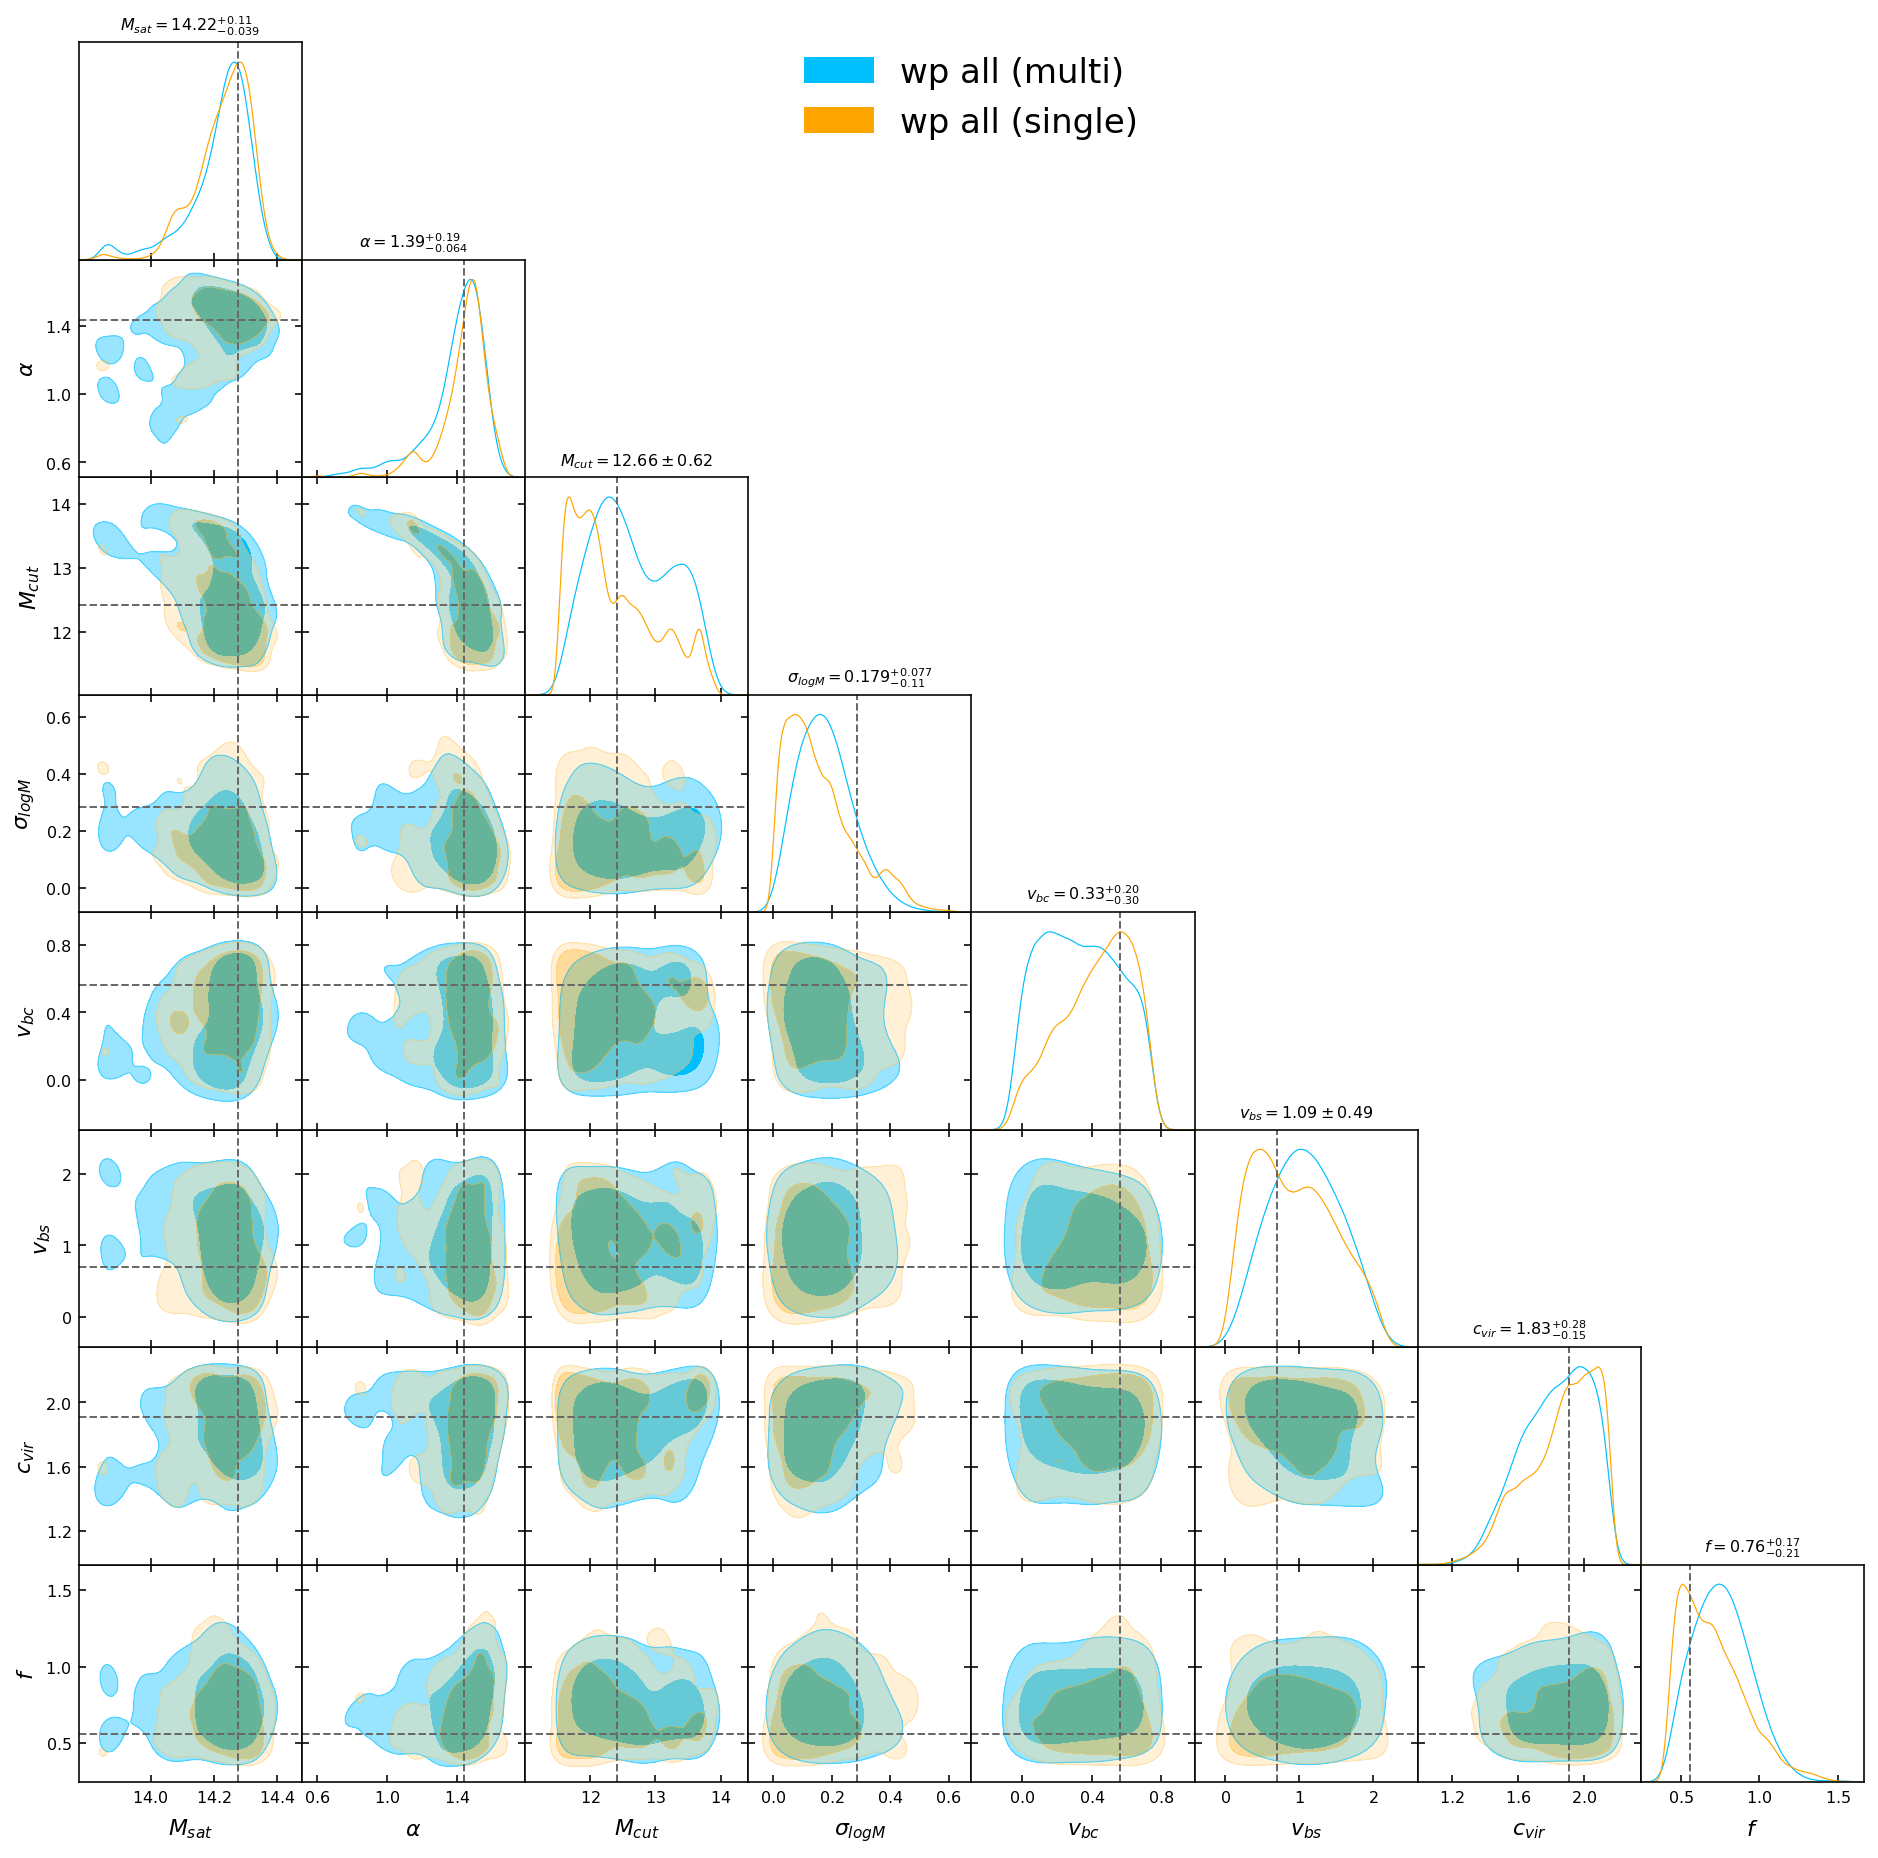

In [16]:
# checking that plotting from res is same
legend_labels = ['wp all (multi)',
                 'wp all (single)']
chaintags = ['wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_single']
colors = [cwp, 'orange']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[True, True],
                      legend_labels=legend_labels, params_toplot=hod_params)

<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
3201 7
(3201, 7) (3201,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
3224 7
(3224, 7) (3224,)


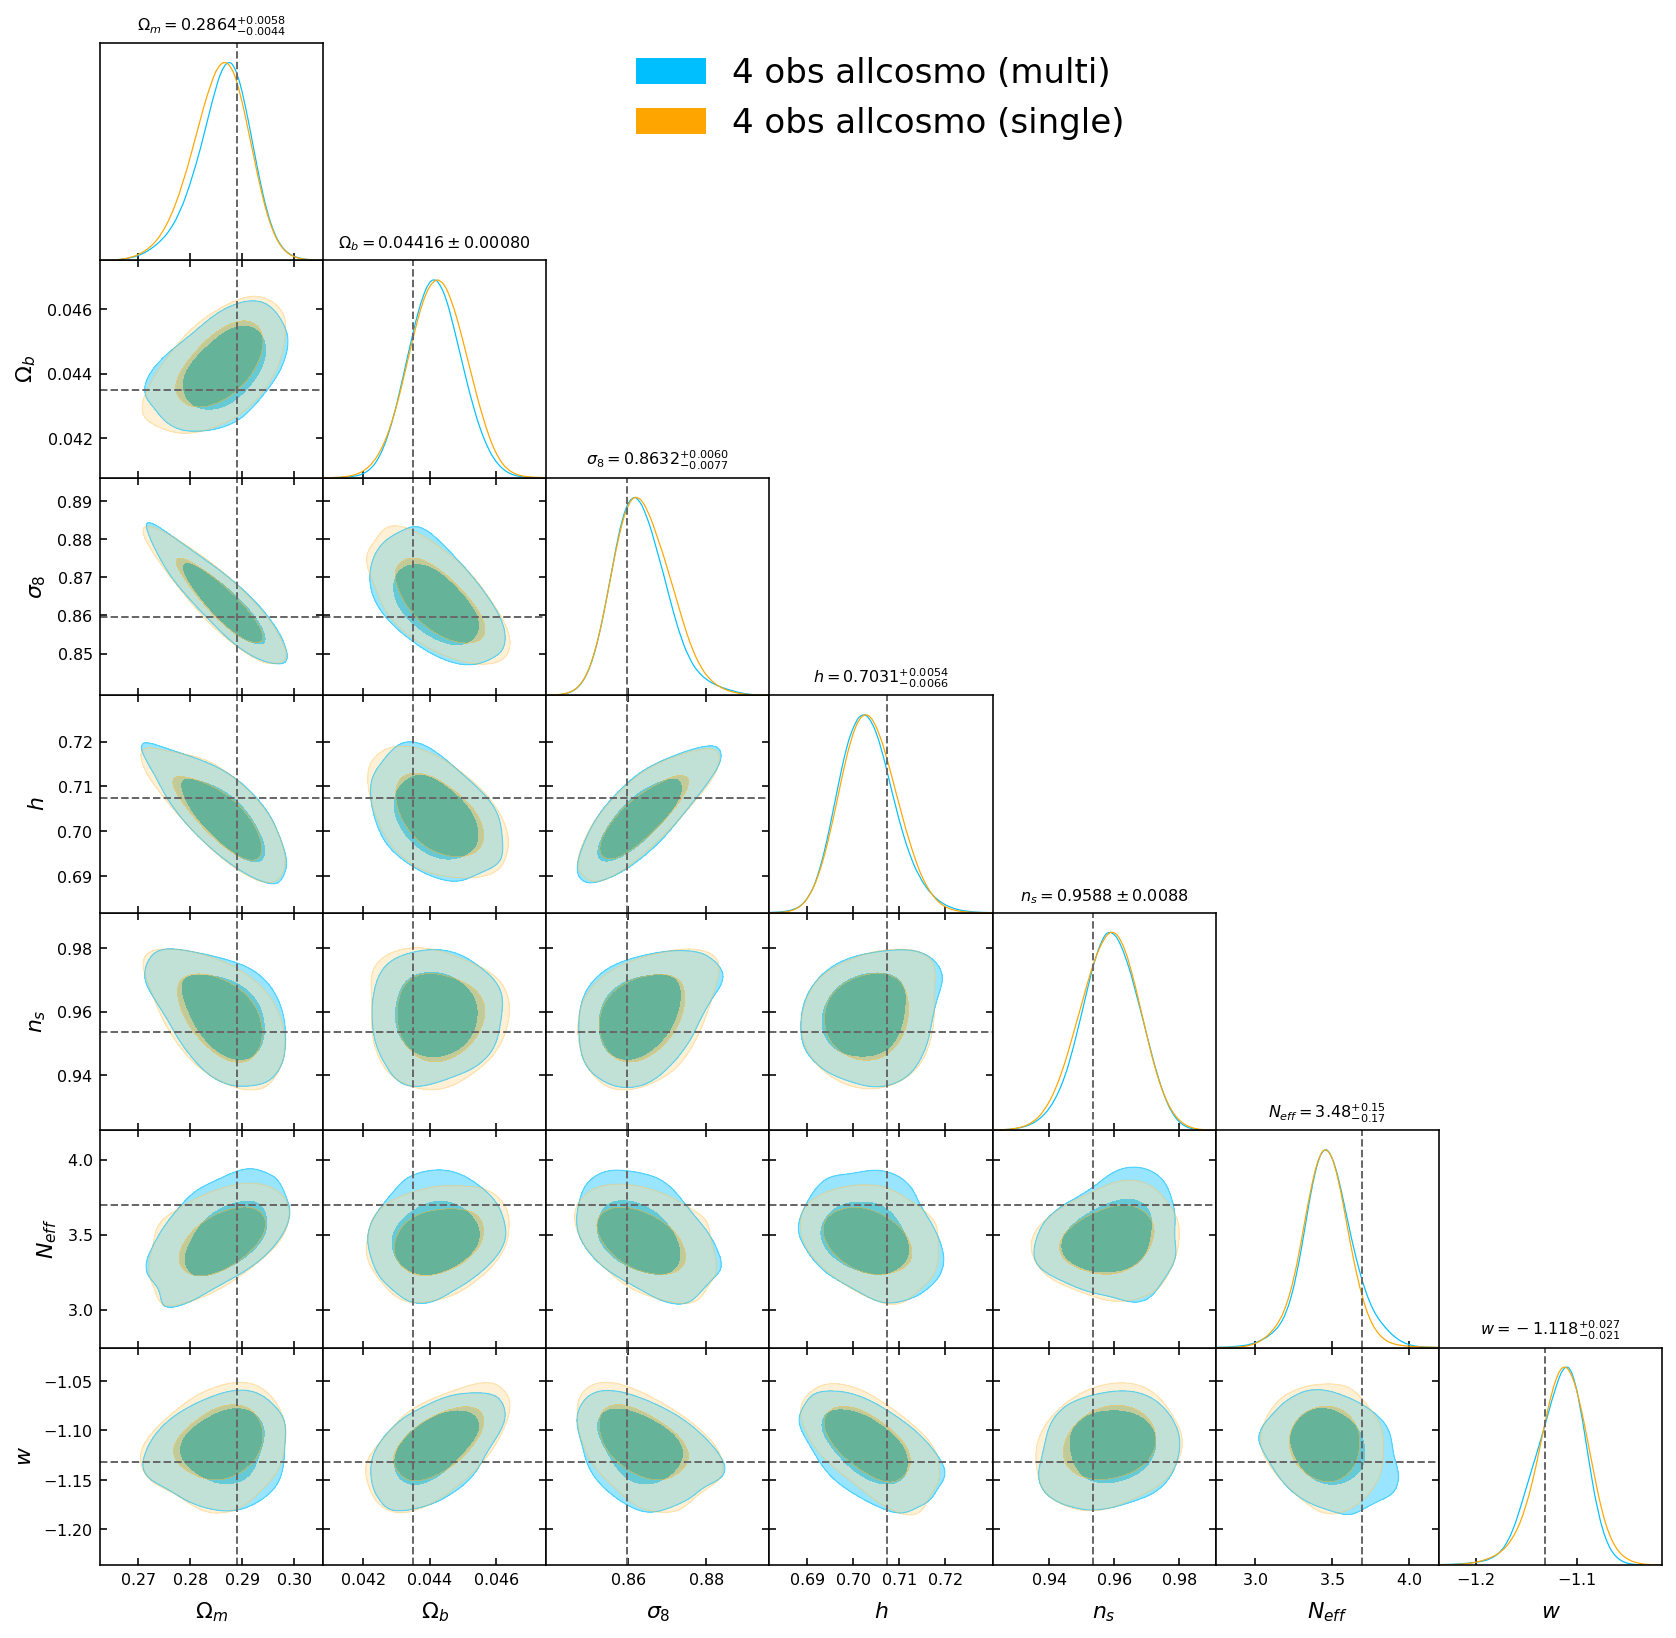

In [14]:
# checking that plotting from res is same
legend_labels = ['4 obs allcosmo (multi)',
                 '4 obs allcosmo (single)']
chaintags = ['wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_xi_upf_mcf_c3h3_allcosmo_dynesty_dlogz1e-2_nongen_hpriorg_single']
colors = [cwp, 'orange']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[True, True],
                      legend_labels=legend_labels)

<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27912 7
(27912, 7) (27912,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27763 7
(27763, 7) (27763,)


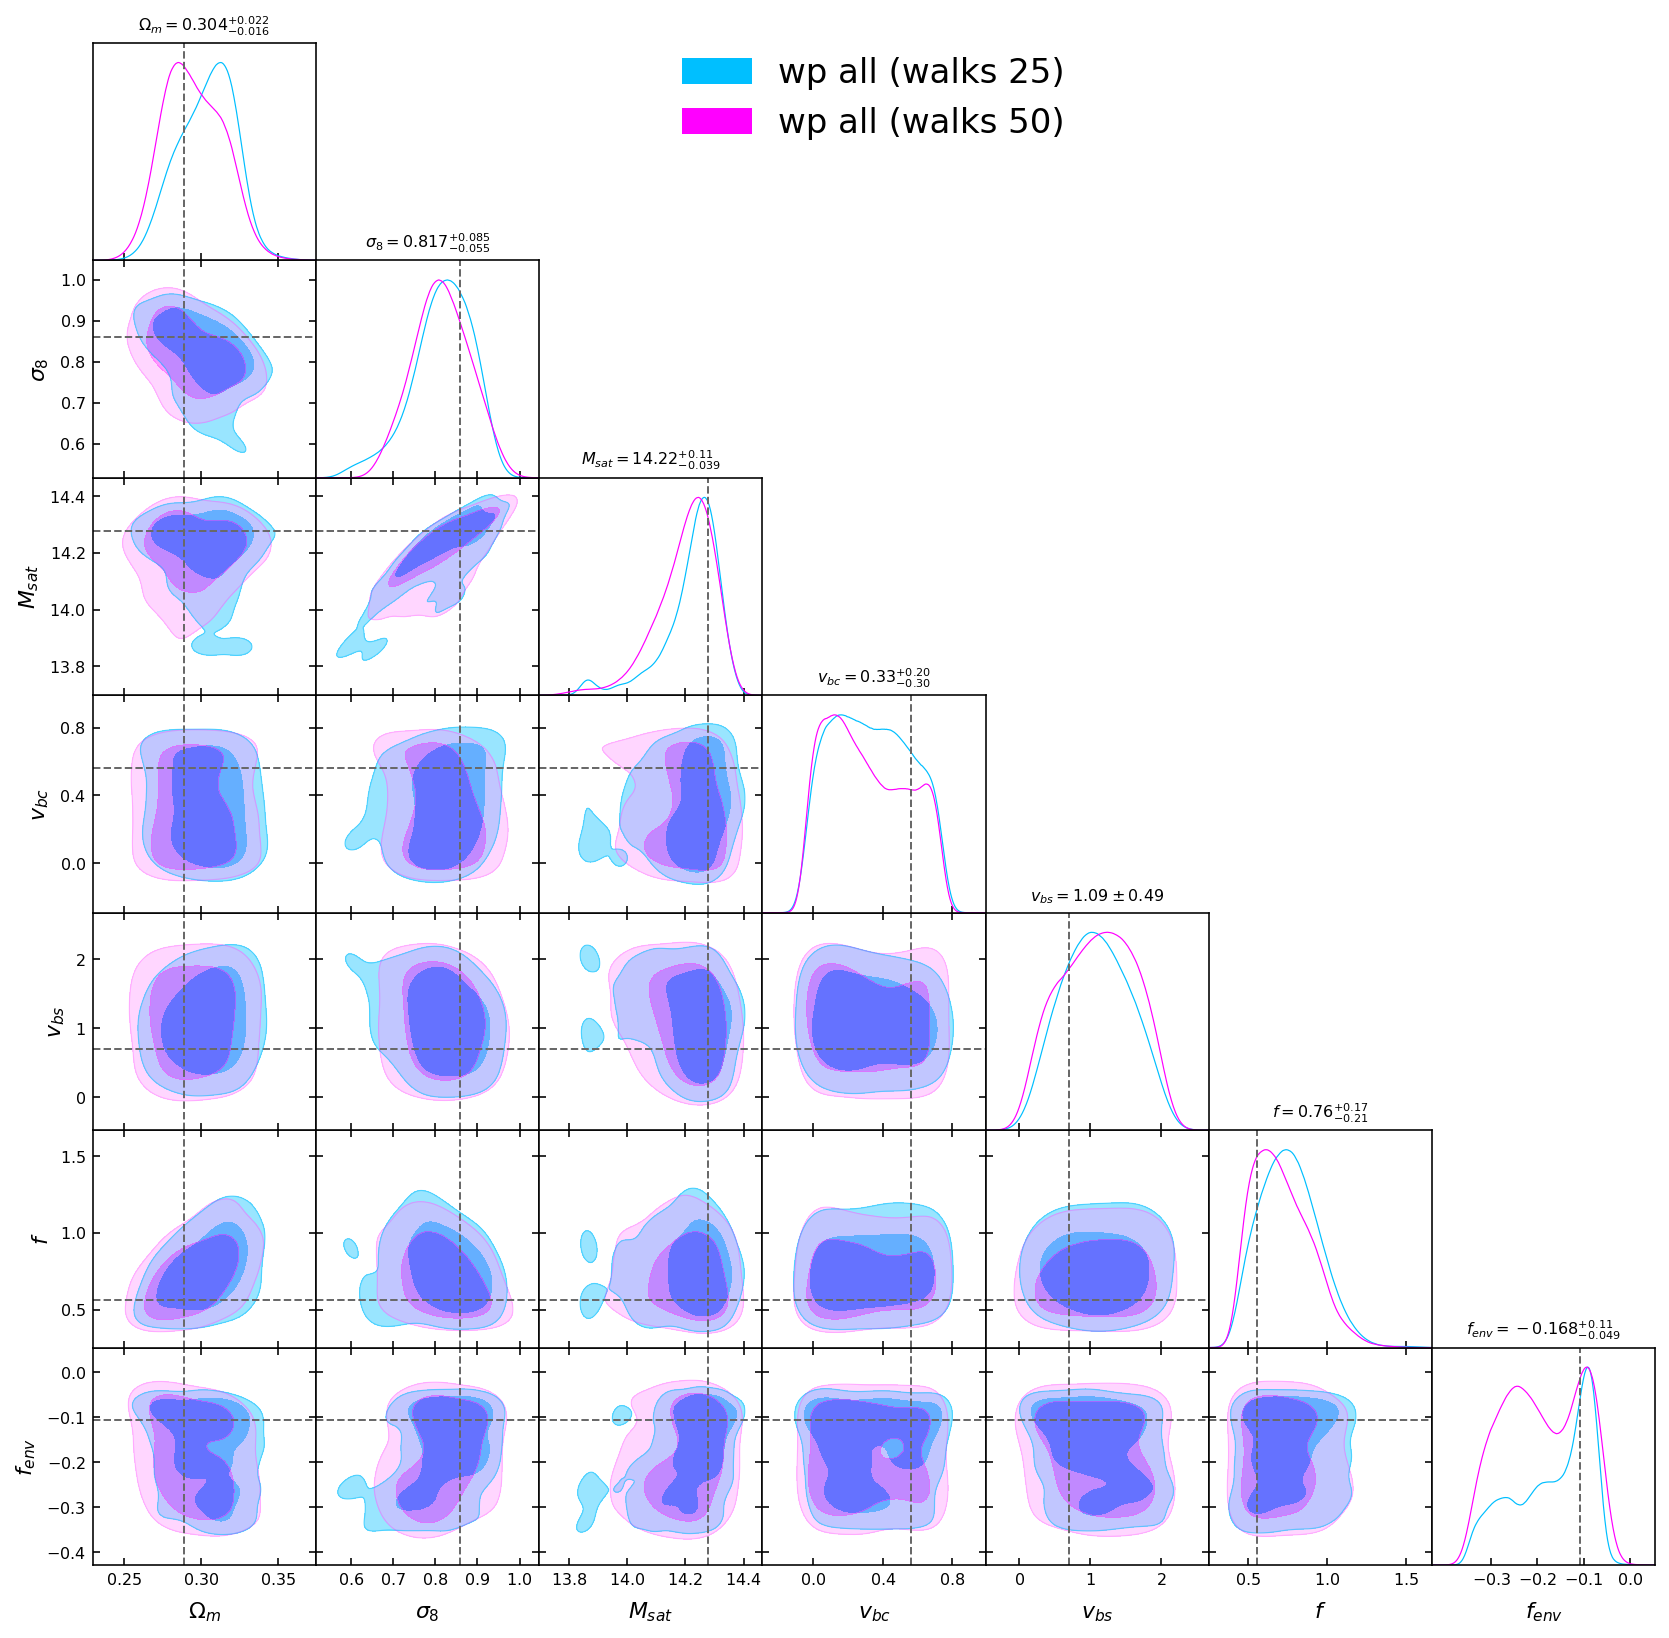

In [14]:
# checking that plotting from res is same
legend_labels = ['wp all (walks 25)',
                 'wp all (walks 50)']
chaintags = ['wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_walks50']
colors = [cwp, 'magenta']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[True, True],
                      legend_labels=legend_labels, params_toplot=key_params)

<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27912 8
(27912, 8) (27912,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27763 8
(27763, 8) (27763,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
28345 8
(28345, 8) (28345,)


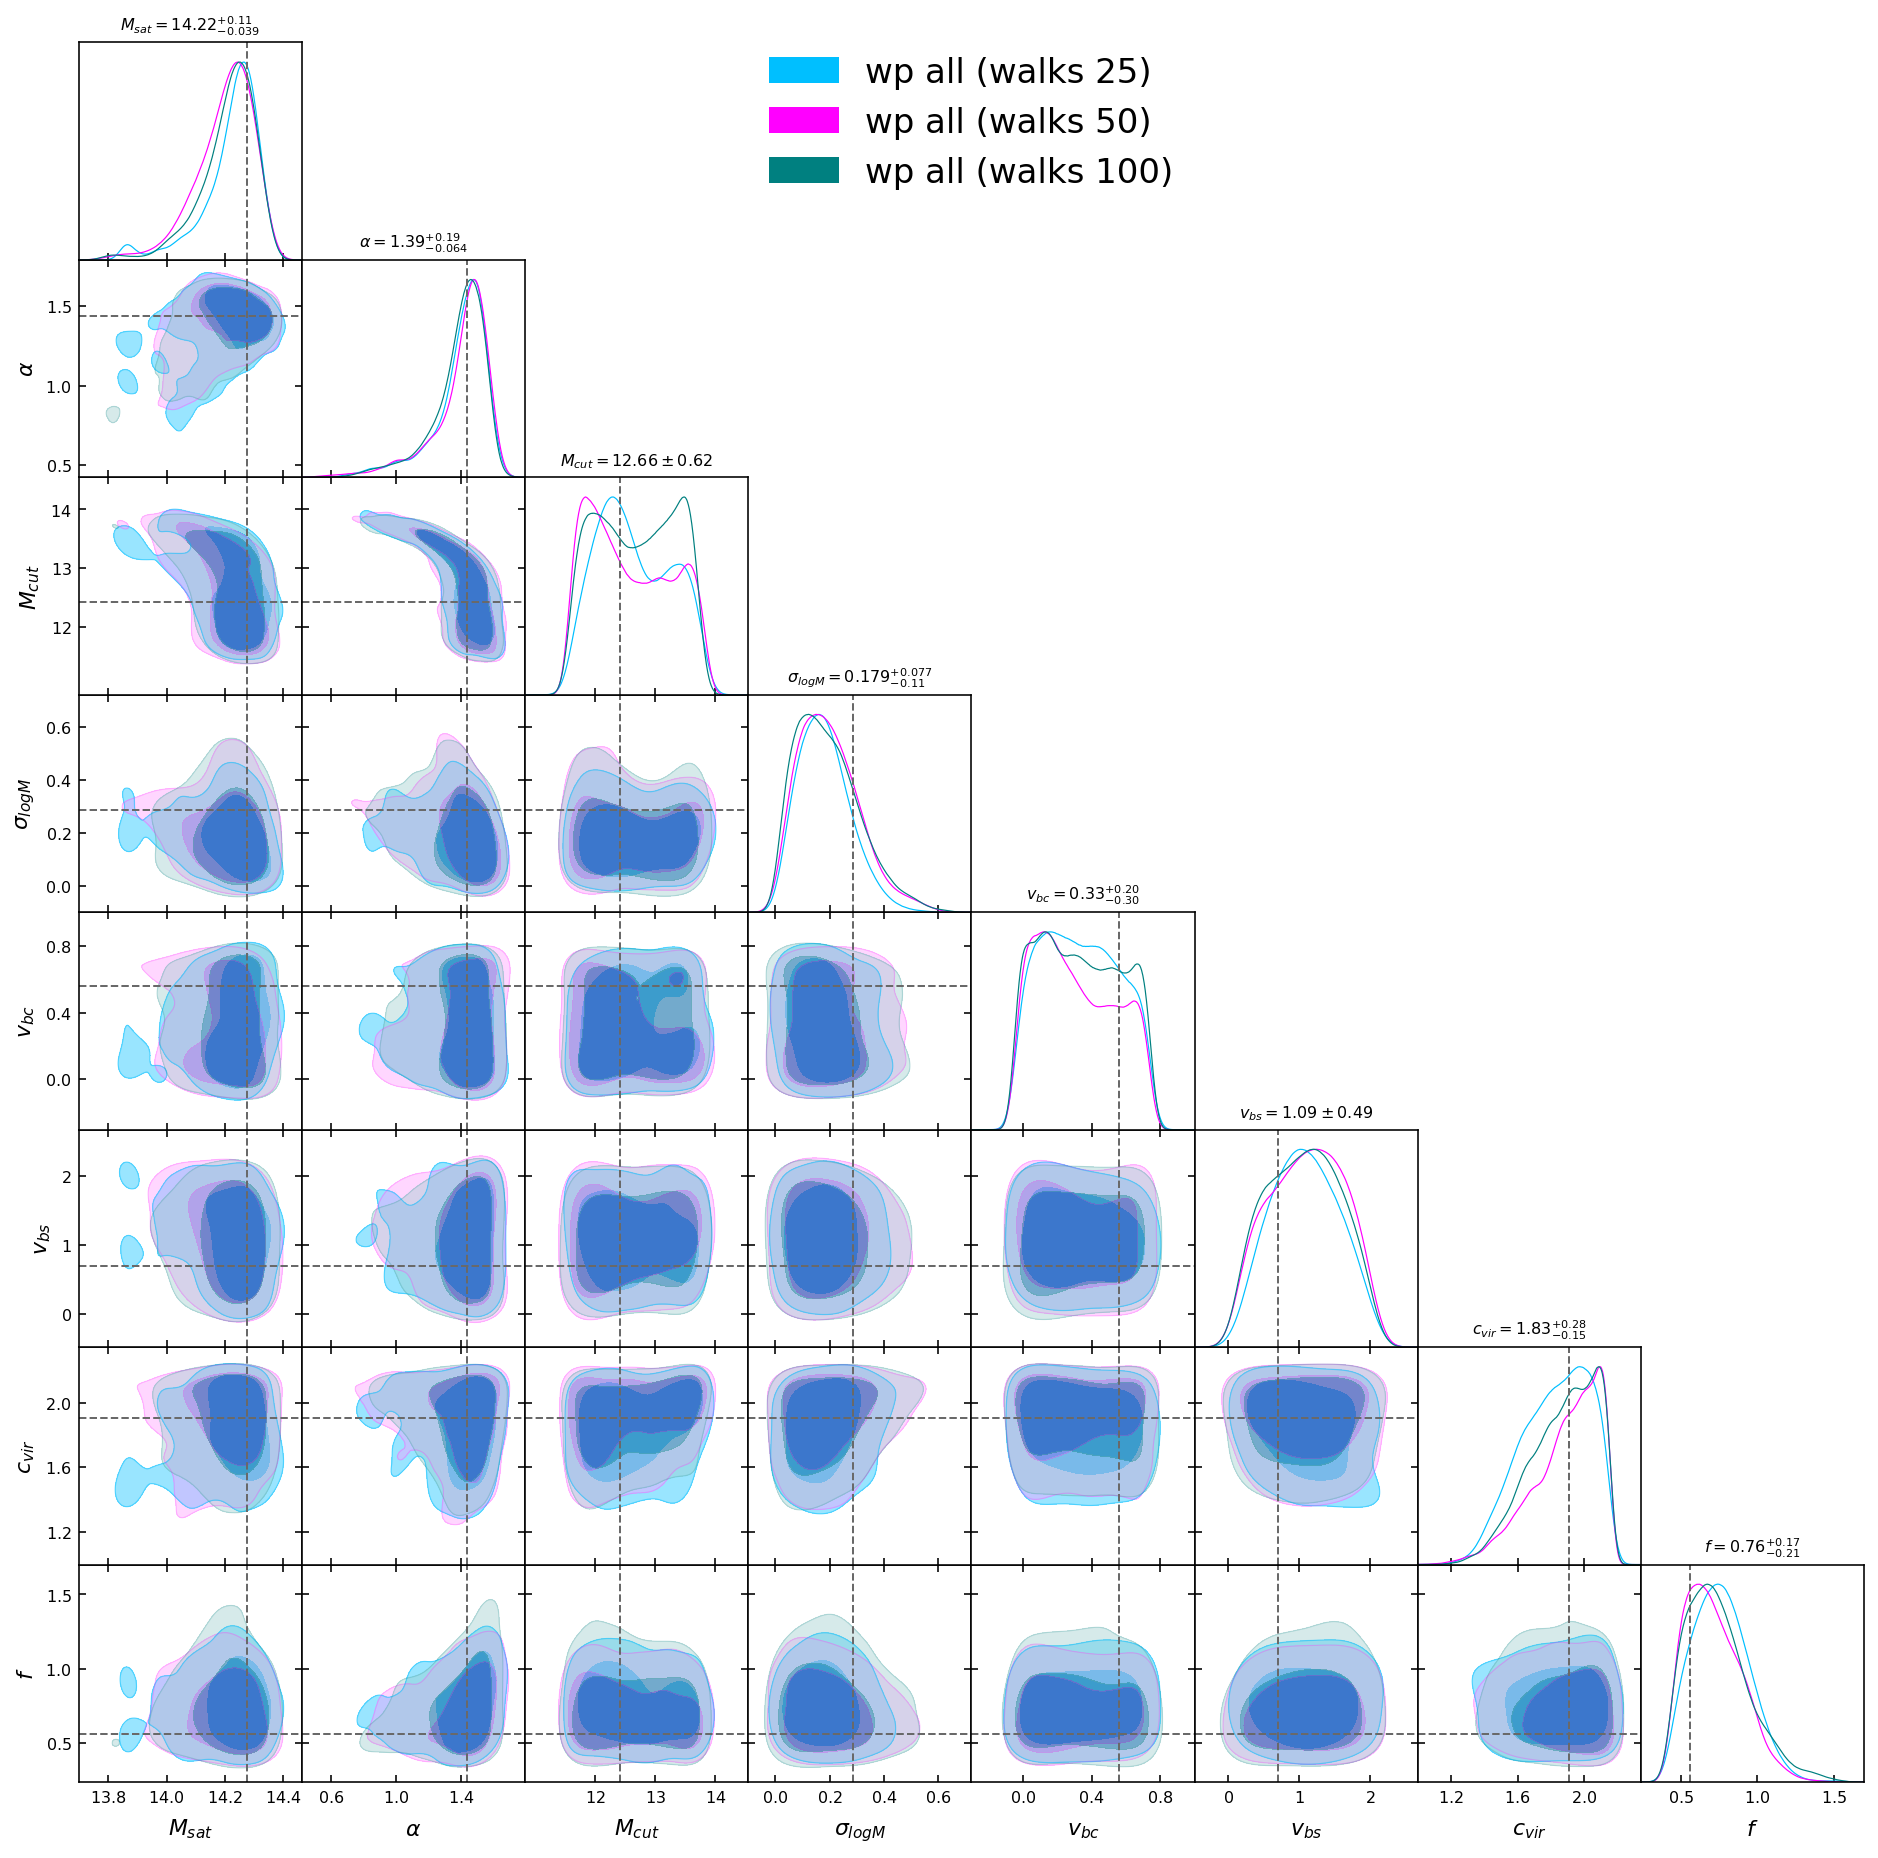

In [14]:
# checking that plotting from res is same
legend_labels = ['wp all (walks 25)',
                 'wp all (walks 50)',
                 'wp all (walks 100)']
chaintags = ['wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_walks50',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_walks100']
colors = [cwp, 'magenta', 'teal']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[True, True, True],
                      legend_labels=legend_labels, params_toplot=hod_params)

### multi params: vol_dec and vol_check

<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27912 7
(27912, 7) (27912,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
27748 7
(27748, 7) (27748,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
28143 7
(28143, 7) (28143,)
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnw

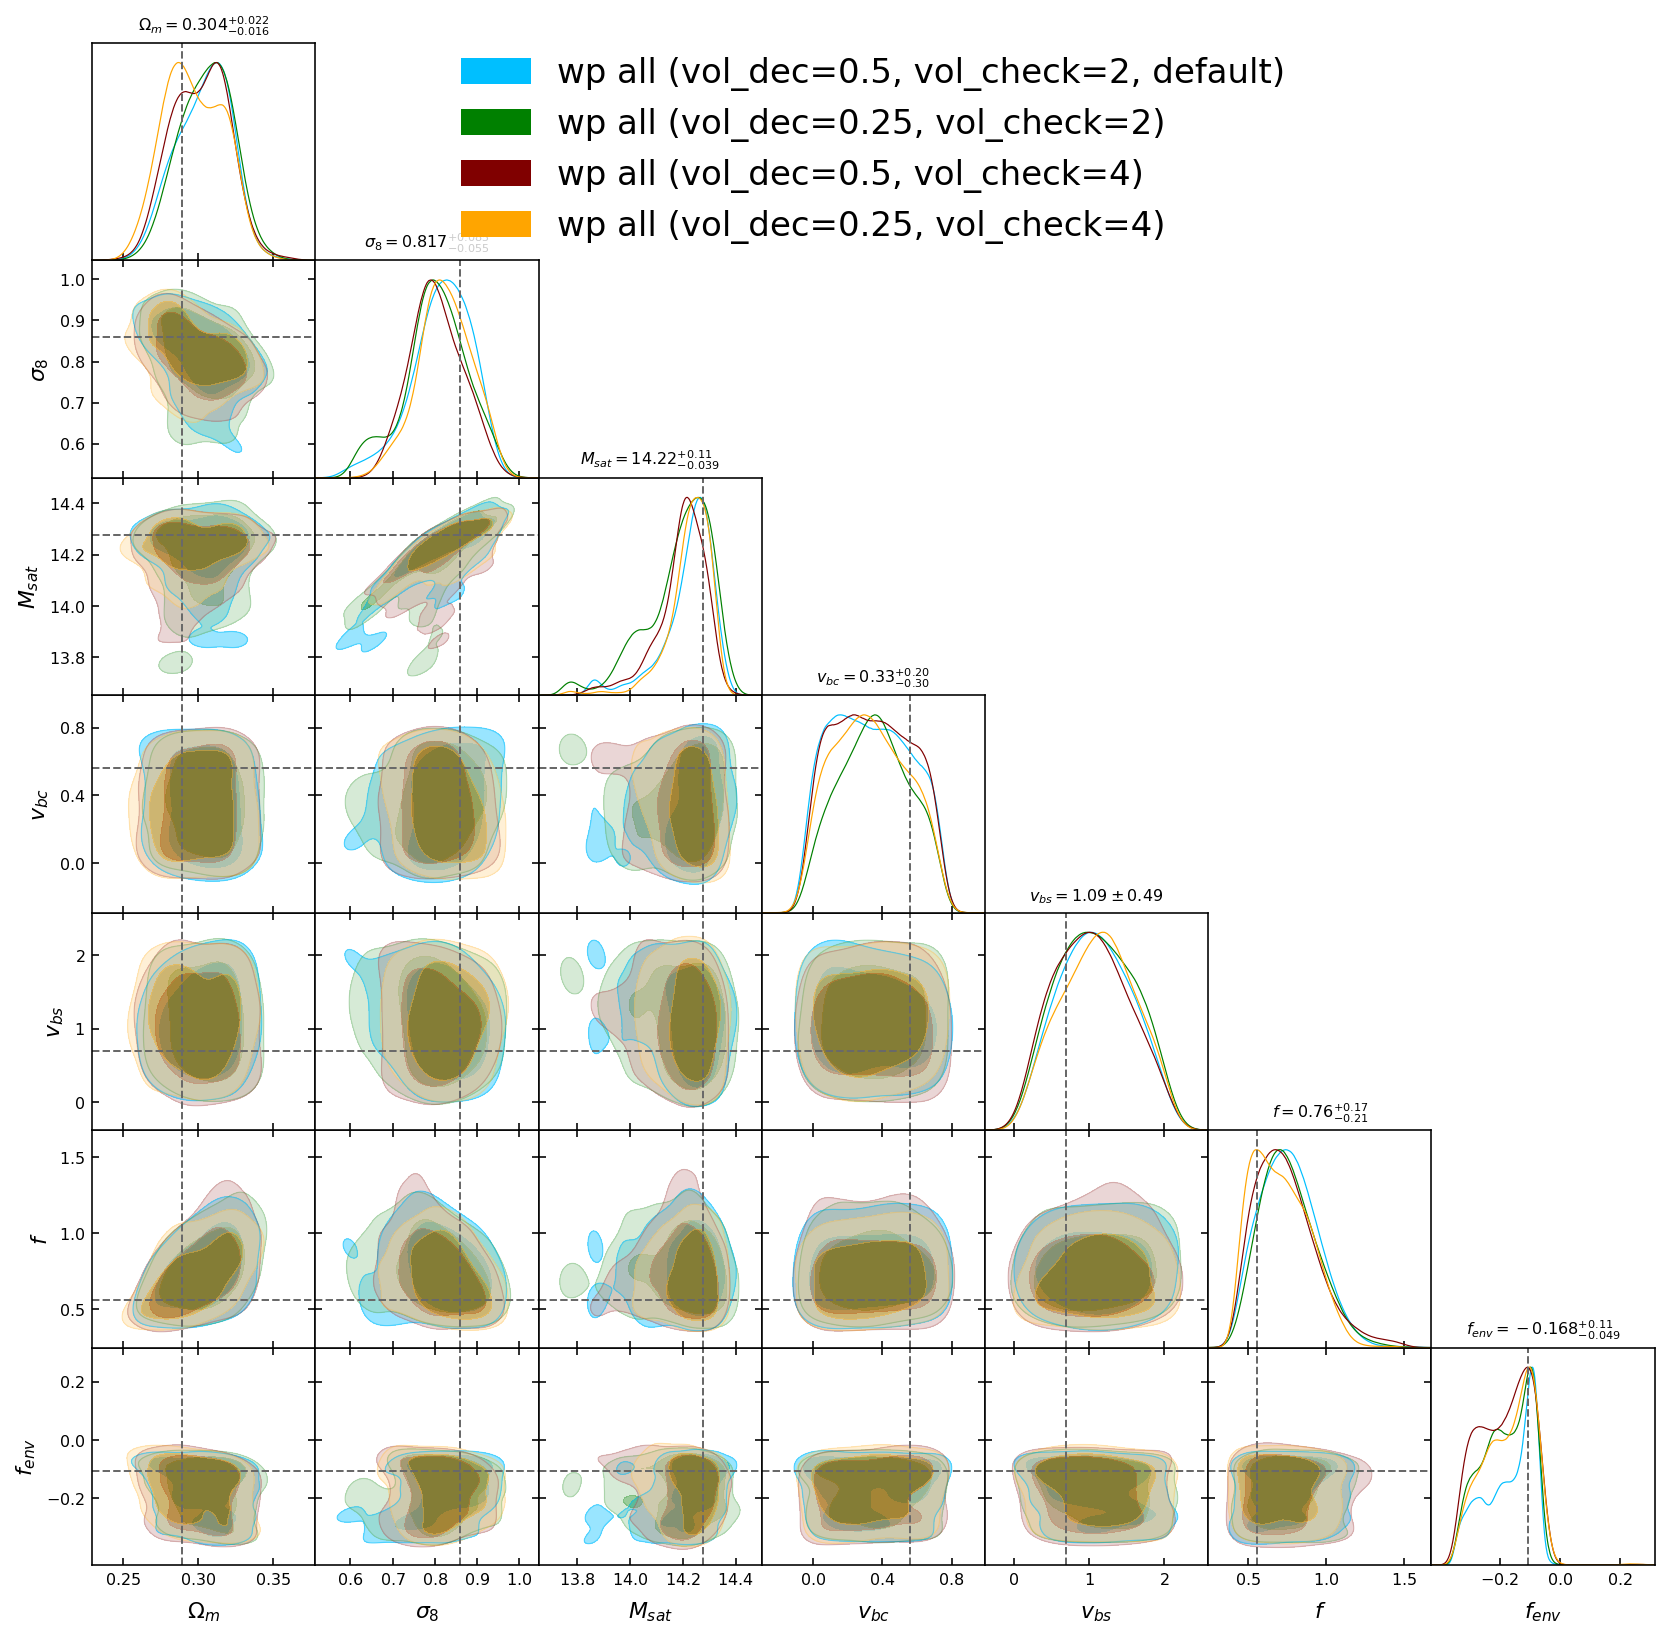

In [13]:
# checking that plotting from res is same
legend_labels = ['wp all (vol_dec=0.5, vol_check=2, default)',
                 'wp all (vol_dec=0.25, vol_check=2)',
                 'wp all (vol_dec=0.5, vol_check=4)',
                 'wp all (vol_dec=0.25, vol_check=4)']
chaintags = ['wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_voldec0.25',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_volcheck4',
             'wp_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg_voldec0.25_volcheck4']
colors = [cwp, 'green', 'maroon', 'orange']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[True, True, True, True],
                      legend_labels=legend_labels, params_toplot=key_params)

21000 7
49532 7


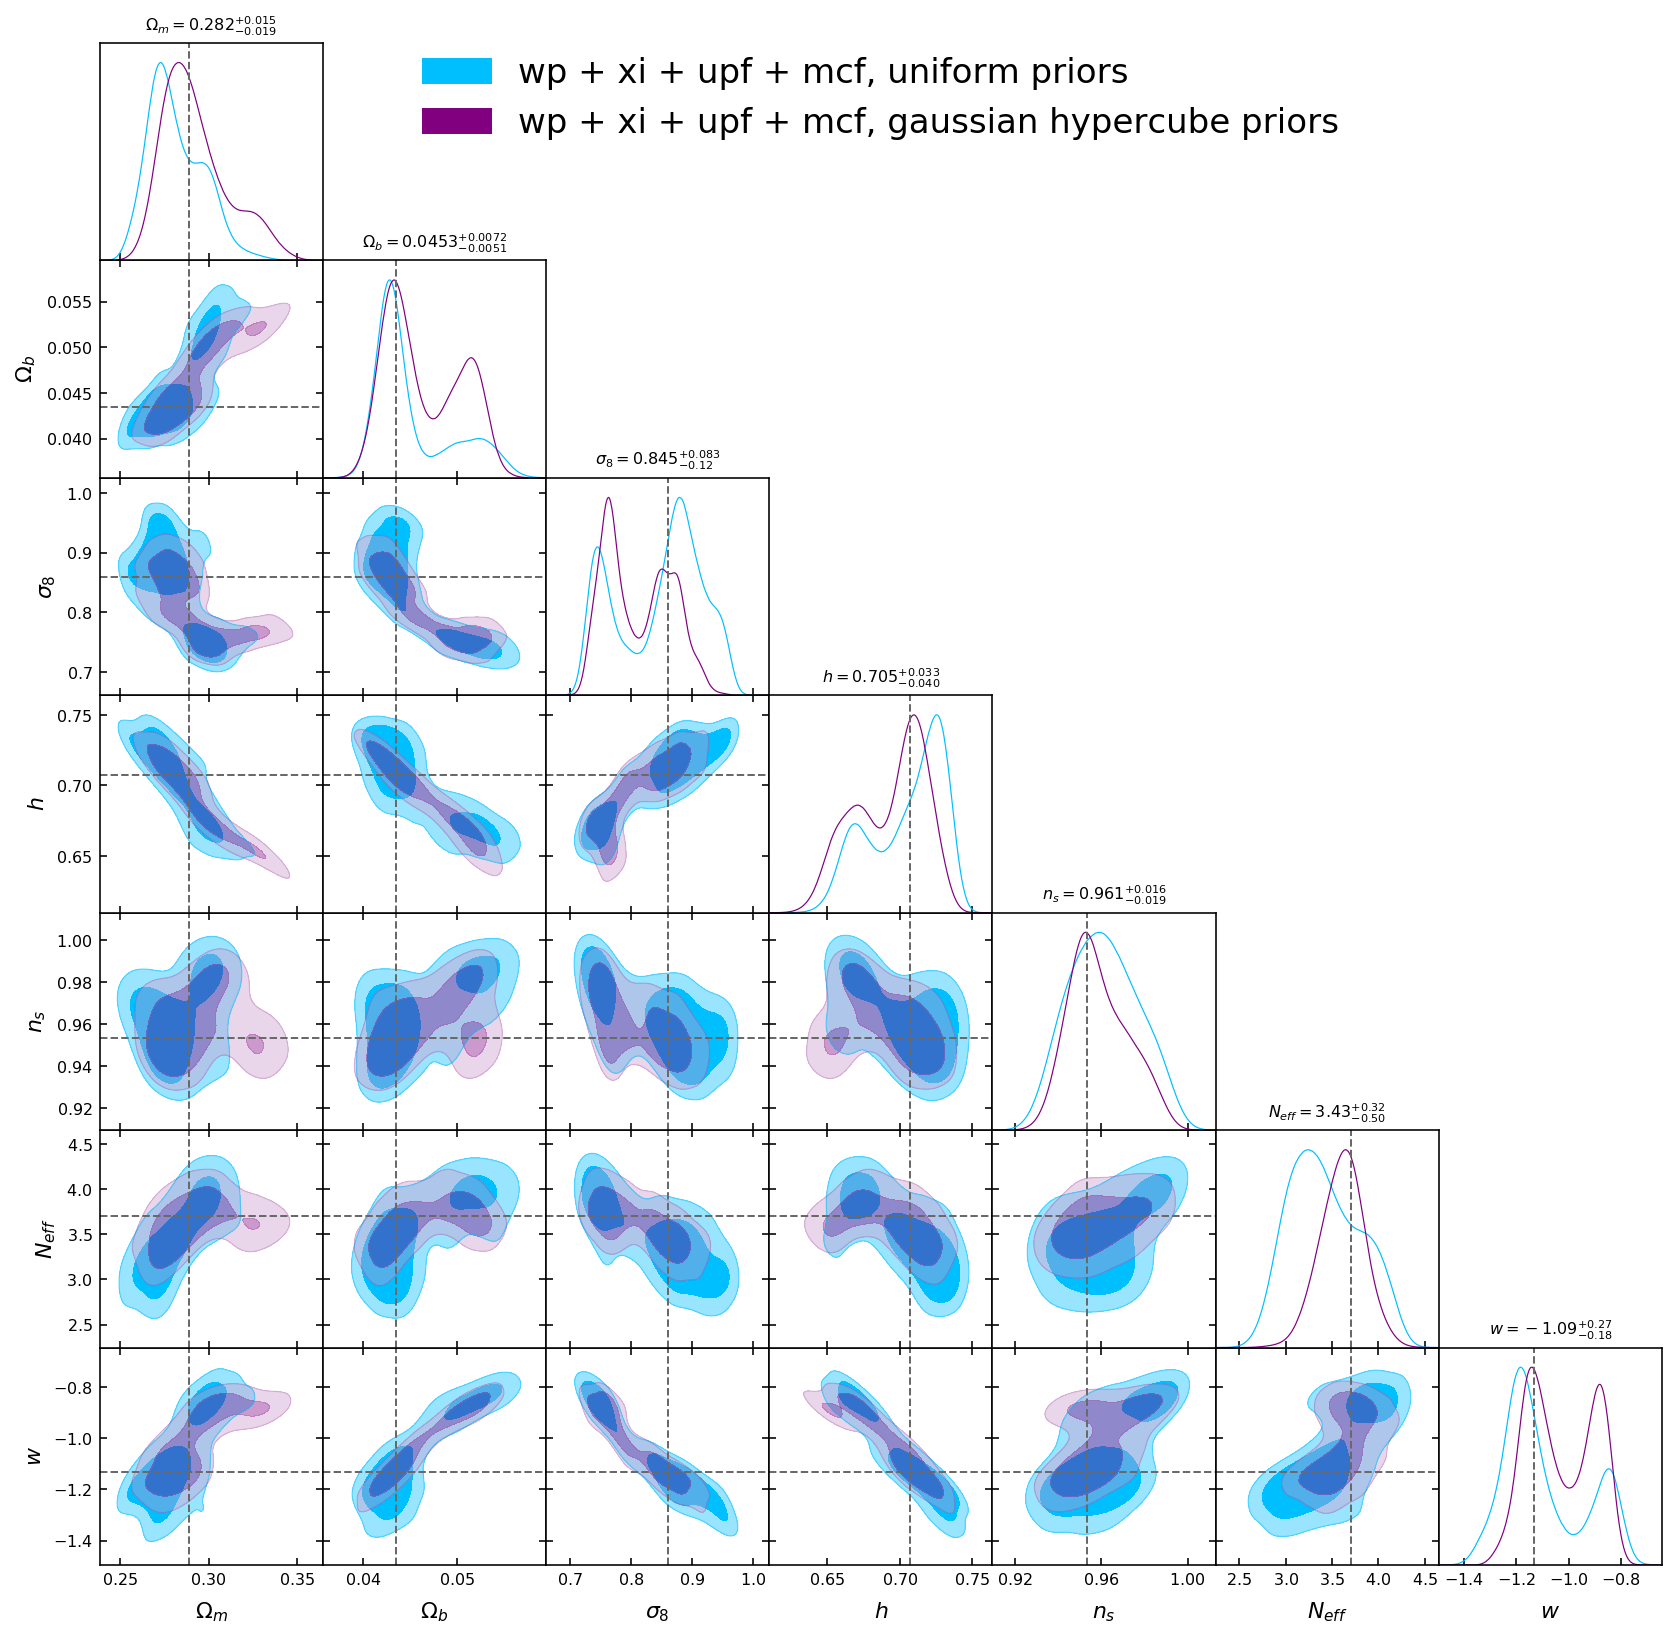

In [22]:
legend_labels = ['wp + xi + upf + mcf, uniform priors',
                 'wp + xi + upf + mcf, gaussian hypercube priors']
chaintags = ['wp_xi_upf_mcf_c3h3_all_dynesty_dlogz001_seed12',
             'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg']
colors = [cwp, 'purple']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[False, False],
                      legend_labels=legend_labels, params_toplot=cosmo_params)

wp_xi_upf_mcf_c3h3_all_dynesty_dlogz001_seed12
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
21000 7
(21000, 7) (21000,)
wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg
<KeysViewHDF5 ['chain', 'lnevidence', 'lnprob', 'lnweight', 'varlnevidence']>
<KeysViewHDF5 ['cosmo', 'dlogz', 'errtag', 'hod', 'kernel_name', 'log', 'mean', 'multi', 'nburn', 'nhod', 'nsteps', 'nwalkers', 'param_names', 'seed', 'statistic', 'tag', 'testtag', 'traintag', 'true_values']>
49532 7
(49532, 7) (49532,)


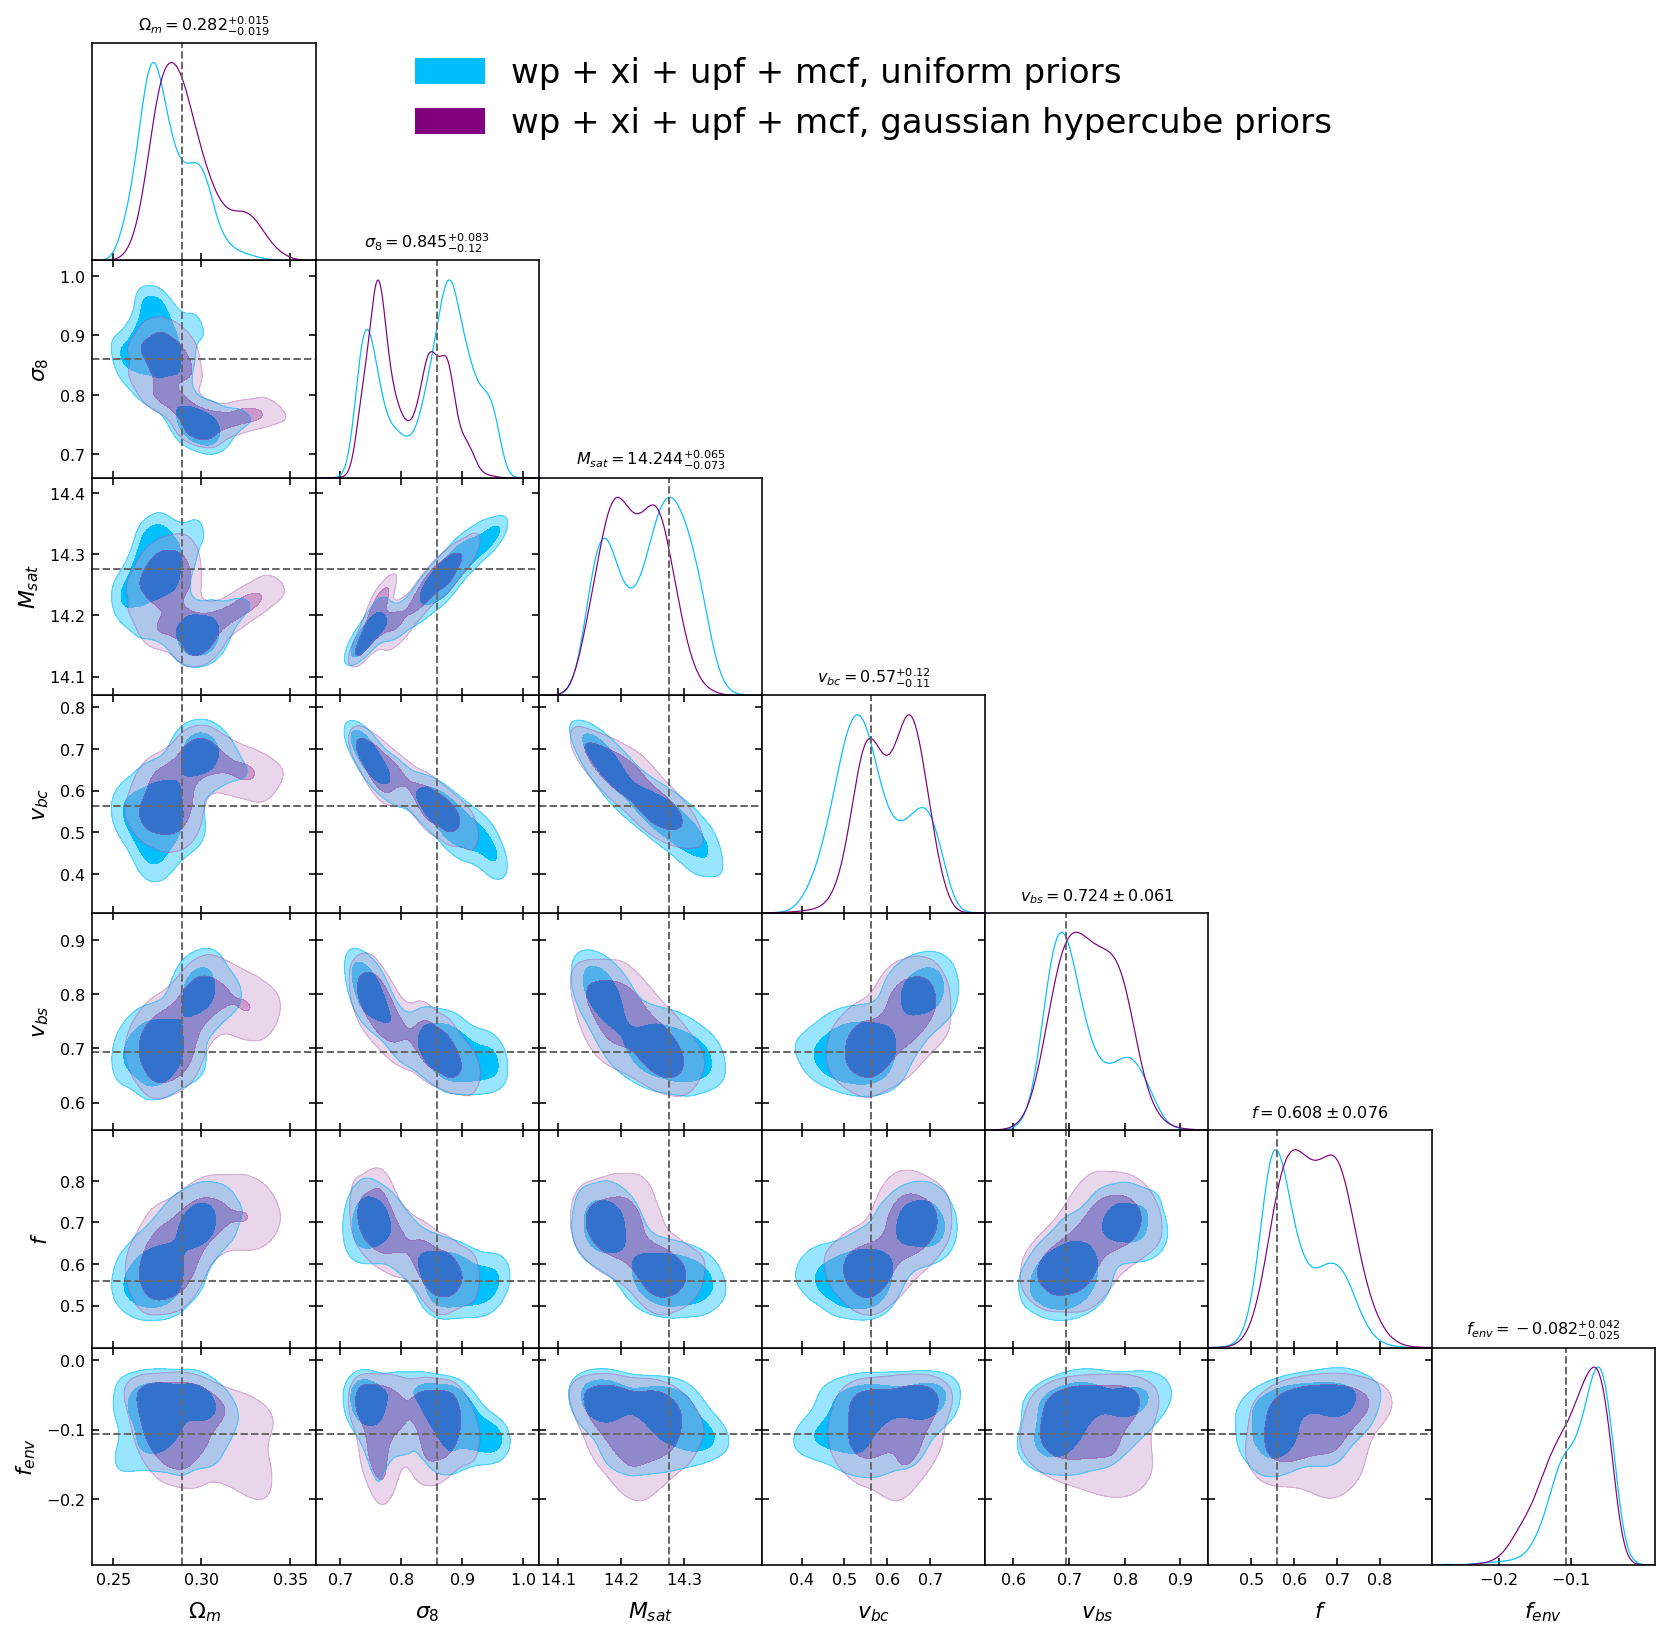

In [20]:
legend_labels = ['wp + xi + upf + mcf, uniform priors',
                 'wp + xi + upf + mcf, gaussian hypercube priors']
chaintags = ['wp_xi_upf_mcf_c3h3_all_dynesty_dlogz001_seed12',
             'wp_xi_upf_mcf_c3h3_all_dynesty_dlogz1e-2_nongen_hpriorg']
colors = [cwp, 'purple']
figure = plot_contours_resample(chaintags, colors=colors, use_res=[False, False],
                      legend_labels=legend_labels, params_toplot=key_params)